## **1. Install Dependencies**
Installs a specific version of the `ultralytics` library to ensure compatibility and consistent behavior for the YOLOv11 pipeline.

**This project uses the Ultralytics YOLOv11 framework for detection. Code structure and hyperparameters are our own; API usage follows the official docs.**

In [1]:
!pip install ultralytics==8.3.30

## **2. Data Ingestion**
Connects the Colab environment to Google Drive, allowing the notebook to access and load the necessary datasets for training.

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("Drive mounted")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted


# **Datasets, Documentation & Inspiration:**

**1-Class Waldo Dataset**

  •	Pooja Walley (Roboflow, 2022-09-01, 9:38 am) — https://universe.roboflow.com/pooja1/pooja_walley

  •	Waldo (Roboflow, 2024-09-24, 1:04 am) — https://universe.roboflow.com/odroid-rh-jf8lr/waldo-dgdq1

Both provided by Roboflow users under the CC BY 4.0 License.

**4-Class Waldo Dataset**

  •	Wally (Roboflow, 2022-03-07, 10:14 pm) — https://universe.roboflow.com/new-workspace-qplfj/wally-rbk6w

Provided by a Roboflow user under the CC BY 4.0 License.

**Model Documentation**

  •	YOLOv11 Models — https://docs.ultralytics.com/models/yolo11/
Official Ultralytics documentation for YOLOv11 architecture, usage, and training guidelines.

**Inspiration & Related Work**

  •	Miao, B. H., & Lesh, A. (2024). Development of WaldoNet: A Novel Approach to Solving “Where’s Waldo”. Stanford University.

The WaldoNet study applied YOLOv9 to small-object detection in Where’s Waldo, using:

  •	A 1-class model (Waldo only) and a 4-class model (Waldo, Wenda, Odlaw, Wizard Whitebeard)

  •	Publicly available Roboflow datasets for baseline training, later improved with a larger, face-focused dataset

  •	Hyperparameter tuning (learning rate, batch size, epochs)

  •	High-resolution images and consistent annotation strategies to improve accuracy

**Connection to this work:**

Our implementation follows a similar staged 1-class → 4-class training strategy to transfer Waldo-specific features into a multi-class model. We also prioritise high-resolution training (imgsz=1280) and controlled augmentations to tackle the challenges of small-object detection in busy backgrounds. While WaldoNet used YOLOv9 and synthetic face crops, our approach uses YOLOv11x with different datasets, augmentation parameters, and fine-tuning settings.


## **3. Optimize Data Access with Symbolic Links**
Creates symbolic links to the dataset directories on Google Drive, enabling faster and more efficient data loading during the training pipeline.

In [3]:
DRIVE_ROOT   = "/content/drive/MyDrive"

ONECLS_ROOT  = f"{DRIVE_ROOT}/Waldo_revised"
FOURCLS_ROOT = f"{DRIVE_ROOT}/wally_multiclass"
FULLPAGE_DIR = f"{DRIVE_ROOT}/Waldo_Fullpage"

import os, shutil, glob

DATA1C = "/content/dataset_1c"
DATA4C = "/content/dataset_4c"

# Symlink (faster than copying)
for src, dest in [(ONECLS_ROOT, DATA1C), (FOURCLS_ROOT, DATA4C)]:
    # Remove if exists
    if os.path.islink(dest) or os.path.exists(dest):
        shutil.rmtree(dest, ignore_errors=True)
    # Create symlink but ignore FileExistsError
    try:
        os.symlink(src, dest)
    except FileExistsError:
        pass

print("Linked datasets:")
!ls -la /content | grep dataset_


Linked datasets:
lrwxrwxrwx 1 root root        36 Aug 13 20:52 dataset_1c -> /content/drive/MyDrive/Waldo_revised
lrwxrwxrwx 1 root root        39 Aug 13 20:52 dataset_4c -> /content/drive/MyDrive/wally_multiclass


## **4. Configure Dataset Pipelines**
Generates `data.yaml` configuration files that define the dataset paths and class names for both the single-class and four-class YOLO training pipelines.

In [4]:
# 1-class
open('/content/data_1cls.yaml','w').write(f"""

path: {DATA1C}

train: train/images

val: valid/images

test: test/images

names: [Waldo]

""")

# 4-class
open('/content/data_4cls.yaml','w').write(f"""

path: {DATA4C}

train: train/images

val: valid/images

test: test/images

names: [Odlaw, Waldo, Wilma, Wizard]

""")

!echo "---- data_1cls.yaml ----"; cat /content/data_1cls.yaml
!echo "---- data_4cls.yaml ----"; cat /content/data_4cls.yaml
print("Wrote data YAMLs")


---- data_1cls.yaml ----


path: /content/dataset_1c

train: train/images

val: valid/images

test: test/images

names: [Waldo]

---- data_4cls.yaml ----


path: /content/dataset_4c

train: train/images

val: valid/images

test: test/images

names: [Odlaw, Waldo, Wilma, Wizard]

Wrote data YAMLs


## **5. Execute Model Training Pipeline**
Initializes and executes the YOLOv11x training pipeline, fine-tuning the model on the single-class "Waldo" dataset using specified hyperparameters and a robust data augmentation strategy.

This training configuration is optimized for high-resolution object detection, focusing on creating a robust and accurate model. Here's a breakdown of the parameter choices:

### **Primary Training Settings**
* **Image Resolution (`imgsz=1280`)**: Images are resized to a high resolution of 1280x1280. This helps the model detect smaller objects and finer details within the images.
* **Training Duration (`epochs=80`)**: The model iterates through the entire dataset 80 times, allowing for comprehensive learning and convergence.
* **Batch Size (`batch=4`)**: The model processes images in small groups of four, a common practice when working with high-resolution images to manage memory usage.
* **Optimization Algorithm (`optimizer='SGD'`)**: Stochastic Gradient Descent is selected as the optimizer to guide the model's learning process by adjusting its internal parameters.
* **Initial Learning Rate (`lr0=0.01`)**: This sets the starting step size for the optimizer's adjustments.

***

### **System & Performance Optimization**
* **GPU Acceleration (`device=0`)**: Training is assigned to the primary GPU, leveraging its parallel processing power for significant speed improvements.
* **Data Loading (`workers=2`)**: Two parallel processes are dedicated to preparing and feeding data to the GPU, preventing bottlenecks in the input pipeline.
* **Mixed Precision (`amp=True`)**: This enables a technique that combines different numerical precisions during training, leading to faster computations and lower VRAM usage without sacrificing model accuracy.

***

### **Advanced Data Augmentation**
A multi-faceted augmentation strategy is employed to enhance the model's ability to generalize to new, unseen images.
* **Complex Augmentations (`mosaic`, `copy_paste`, `mixup`)**: The pipeline utilizes sophisticated methods that create new training examples by combining multiple images (`mosaic`), inserting objects from one image onto another (`copy_paste`), and blending images together (`mixup`).
* **Geometric Transformations (`translate`, `scale`, `fliplr`)**: Standard augmentations are also applied to randomly alter the position, size, and orientation of objects in the images.
* **Final Epoch Strategy (`close_mosaic=10`)**: The most computationally intensive augmentation, mosaic, is deactivated for the final 10 epochs. This allows the model to fine-tune its learning on individual, unmodified images, which more closely resemble real-world inputs.

In [5]:
from ultralytics import YOLO
import torch, gc, os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:128"
torch.backends.cudnn.benchmark = True

def free_vram():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

IMGSZ = 1280
BATCH = 4
ACCUM = 2
WORKERS = 2

free_vram()
model_1c = YOLO('yolo11x.pt')
r1 = model_1c.train(
    data='/content/data_1cls.yaml',
    imgsz=IMGSZ,
    epochs=80,
    batch=BATCH,
    lr0=0.01,
    optimizer='SGD',
    device=0,
    workers=WORKERS,
    amp=True,
    mosaic=1.0, copy_paste=0.3, mixup=0.1,
    translate=0.10, scale=0.20, fliplr=0.5, flipud=0.0,
    close_mosaic=10,
    multi_scale=False,
    project='runs/detect', name='waldo_1c_y11x_1280', exist_ok=True,
)
best_1c = model_1c.ckpt_path
print("1‑class best:", best_1c)


New https://pypi.org/project/ultralytics/8.3.178 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.30 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11x.pt, data=/content/data_1cls.yaml, epochs=80, time=None, patience=100, batch=4, imgsz=1280, save=True, save_period=-1, cache=False, device=0, workers=2, project=runs/detect, name=waldo_1c_y11x_1280, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None

train: Scanning /content/drive/MyDrive/Waldo_revised/train/labels... 107 images, 1 backgrounds, 0 corrupt: 100%|██████████| 107/107 [00:04<00:00, 24.64it/s]

train: New cache created: /content/drive/MyDrive/Waldo_revised/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/Waldo_revised/valid/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 18.52it/s]

val: New cache created: /content/drive/MyDrive/Waldo_revised/valid/labels.cache


Plotting labels to runs/detect/waldo_1c_y11x_1280/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 2 dataloader workers
Logging results to runs/detect/waldo_1c_y11x_1280
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      2.57G      3.332      40.74        2.7          4       1280: 100%|██████████| 27/27 [00:20<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.65s/it]

                   all         10         10   0.000667        0.2    0.00785    0.00232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80        41G      3.167      21.96      2.638          1       1280: 100%|██████████| 27/27 [00:09<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.98it/s]

                   all         10         10   0.000667        0.2    0.00437    0.00174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      34.9G       2.83       5.78      2.395          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.94it/s]

                   all         10         10      0.001        0.3     0.0573     0.0161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      23.8G      2.634      4.786      2.226          5       1280: 100%|██████████| 27/27 [00:08<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.77it/s]

                   all         10         10      0.862        0.2      0.196     0.0876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      12.4G      2.628      5.036      2.233          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.44it/s]

                   all         10         10    0.00242        0.2      0.163     0.0588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      14.1G      2.375      4.392       1.94          4       1280: 100%|██████████| 27/27 [00:09<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.28it/s]

                   all         10         10          1      0.196      0.195        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      13.4G      2.509      4.275       2.05          5       1280: 100%|██████████| 27/27 [00:09<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.42it/s]

                   all         10         10    0.00216        0.1     0.0249    0.00329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      39.9G      2.243      4.148      1.823          6       1280: 100%|██████████| 27/27 [00:08<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.08it/s]

                   all         10         10    0.00497        0.3     0.0337     0.0125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80        27G      2.386      5.698      1.864          5       1280: 100%|██████████| 27/27 [00:09<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.48it/s]

                   all         10         10     0.0766        0.1     0.0976     0.0767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      38.4G      2.305      4.606      1.774          7       1280: 100%|██████████| 27/27 [00:10<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.91it/s]

                   all         10         10   0.000904        0.2    0.00161   0.000411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      21.6G      2.221      4.616      1.799          6       1280: 100%|██████████| 27/27 [00:09<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.72it/s]

                   all         10         10     0.0032        0.2    0.00781    0.00141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      13.5G      2.317      4.326      1.688          4       1280: 100%|██████████| 27/27 [00:08<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.18it/s]

                   all         10         10     0.0015        0.4     0.0245    0.00536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      13.5G      2.325      4.076      1.793          2       1280: 100%|██████████| 27/27 [00:09<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.58it/s]

                   all         10         10     0.0106        0.2     0.0211    0.00822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      39.4G      2.146       4.21      1.814          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.83it/s]

                   all         10         10    0.00127        0.1    0.00375    0.00225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      33.6G      2.159      3.954      1.898          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.58it/s]

                   all         10         10    0.00234        0.4     0.0163    0.00339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      25.9G      2.064      3.099      1.824          2       1280: 100%|██████████| 27/27 [00:10<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.55it/s]

                   all         10         10    0.00334        0.2    0.00262    0.00144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      26.9G      2.088      4.613      1.738          5       1280: 100%|██████████| 27/27 [00:09<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.81it/s]

                   all         10         10    0.00636        0.3    0.00676    0.00308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      14.4G      2.062      3.864      1.805          6       1280: 100%|██████████| 27/27 [00:09<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.19it/s]

                   all         10         10     0.0264        0.2      0.207      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      28.7G      1.985      3.065      1.674          8       1280: 100%|██████████| 27/27 [00:09<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.06it/s]

                   all         10         10     0.0109        0.7     0.0237     0.0127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      12.8G      1.908      2.929      1.699          6       1280: 100%|██████████| 27/27 [00:08<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.61it/s]

                   all         10         10     0.0171        0.1      0.017    0.00558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      12.7G      2.095      3.105       1.59          5       1280: 100%|██████████| 27/27 [00:08<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]

                   all         10         10      0.294        0.2      0.145      0.058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      26.3G      2.068      3.156      1.623          3       1280: 100%|██████████| 27/27 [00:07<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.33it/s]

                   all         10         10     0.0188        0.5     0.0157    0.00582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      38.9G      1.968      2.528      1.699          2       1280: 100%|██████████| 27/27 [00:09<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.99it/s]

                   all         10         10      0.196        0.5      0.211     0.0732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      28.4G      1.933      2.552      1.587          4       1280: 100%|██████████| 27/27 [00:09<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.74it/s]

                   all         10         10      0.201      0.303      0.201     0.0884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      27.4G      2.012      2.756      1.692          5       1280: 100%|██████████| 27/27 [00:09<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.83it/s]

                   all         10         10      0.904        0.1      0.146     0.0607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      13.5G      1.815      2.453      1.484          4       1280: 100%|██████████| 27/27 [00:09<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.26it/s]

                   all         10         10      0.206        0.3      0.231     0.0979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      41.6G      1.845      2.148      1.638          6       1280: 100%|██████████| 27/27 [00:08<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

                   all         10         10       0.47       0.27      0.257      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80        26G      1.936      2.249      1.558          2       1280: 100%|██████████| 27/27 [00:08<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]

                   all         10         10      0.621        0.4      0.415      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      13.2G      2.003      2.297      1.664          6       1280: 100%|██████████| 27/27 [00:08<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.60it/s]

                   all         10         10          1      0.391      0.458      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      37.9G      1.916      2.283      1.577          5       1280: 100%|██████████| 27/27 [00:09<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.47it/s]

                   all         10         10      0.223        0.5      0.253     0.0905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      24.4G      1.758       1.94      1.532          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.62it/s]

                   all         10         10      0.121        0.5      0.116     0.0434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      38.8G      1.734      1.963      1.512          1       1280: 100%|██████████| 27/27 [00:09<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.76it/s]

                   all         10         10       0.41        0.5      0.391      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      13.5G      1.594      1.832      1.468          2       1280: 100%|██████████| 27/27 [00:09<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.69it/s]

                   all         10         10       0.22      0.481      0.151     0.0433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80        27G      1.685      1.876      1.392         10       1280: 100%|██████████| 27/27 [00:08<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.84it/s]

                   all         10         10      0.352        0.3       0.33     0.0882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      28.7G      1.684      1.546      1.384          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.38it/s]

                   all         10         10      0.461        0.5      0.419      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80        27G      1.633      1.653      1.456         10       1280: 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.77it/s]

                   all         10         10      0.505      0.408      0.396      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      13.8G      1.644      1.594      1.399          4       1280: 100%|██████████| 27/27 [00:08<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.74it/s]

                   all         10         10      0.549        0.5       0.54      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      24.1G      1.612      1.544      1.424          7       1280: 100%|██████████| 27/27 [00:09<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.69it/s]

                   all         10         10       0.55        0.6      0.463      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      28.3G      1.526      1.563      1.297          5       1280: 100%|██████████| 27/27 [00:08<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.56it/s]

                   all         10         10      0.427        0.7      0.405      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      25.8G       1.69      1.602      1.429          5       1280: 100%|██████████| 27/27 [00:08<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.34it/s]

                   all         10         10      0.632      0.688      0.492      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      31.8G      1.572      1.484      1.472          9       1280: 100%|██████████| 27/27 [00:07<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.19it/s]

                   all         10         10      0.538        0.7      0.459      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      35.9G       1.65      1.623      1.433          6       1280: 100%|██████████| 27/27 [00:09<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.04it/s]

                   all         10         10      0.995        0.7      0.756      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      28.9G      1.576      1.494      1.318          2       1280: 100%|██████████| 27/27 [00:07<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.57it/s]

                   all         10         10      0.665      0.794      0.686      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      41.8G      1.627      1.568      1.439          6       1280: 100%|██████████| 27/27 [00:08<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         10         10      0.644        0.5      0.577      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      40.3G      1.517      1.456      1.394          5       1280: 100%|██████████| 27/27 [00:09<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.64it/s]

                   all         10         10      0.727        0.8      0.732       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      31.3G      1.591      1.405      1.468          5       1280: 100%|██████████| 27/27 [00:09<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.47it/s]

                   all         10         10      0.899        0.7      0.809      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      25.7G      1.515      1.461      1.403          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.80it/s]

                   all         10         10      0.885       0.77      0.777      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      13.5G      1.493      1.299      1.259          6       1280: 100%|██████████| 27/27 [00:08<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.39it/s]

                   all         10         10      0.724        0.8      0.765      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      37.4G      1.484      1.422       1.32          7       1280: 100%|██████████| 27/27 [00:09<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]

                   all         10         10      0.774        0.8      0.783      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      13.5G      1.512      1.503      1.273          5       1280: 100%|██████████| 27/27 [00:09<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.25it/s]

                   all         10         10      0.677        0.7      0.577      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80        13G      1.534      1.312      1.258          1       1280: 100%|██████████| 27/27 [00:08<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.56it/s]

                   all         10         10      0.659        0.7      0.582      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      40.6G      1.333      1.135      1.267          9       1280: 100%|██████████| 27/27 [00:09<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.14it/s]

                   all         10         10      0.743        0.7      0.606      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      34.1G      1.476      1.255      1.302          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.05it/s]

                   all         10         10      0.743        0.7      0.641      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      14.4G      1.402      1.223      1.282          4       1280: 100%|██████████| 27/27 [00:09<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.52it/s]

                   all         10         10      0.723        0.6      0.634      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      23.8G      1.364      1.103      1.244          1       1280: 100%|██████████| 27/27 [00:10<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.66it/s]

                   all         10         10      0.842        0.7      0.762      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      35.4G      1.449      1.346      1.264          6       1280: 100%|██████████| 27/27 [00:09<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.03it/s]

                   all         10         10          1      0.787      0.803      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      40.2G      1.471      1.232      1.296          5       1280: 100%|██████████| 27/27 [00:09<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.05it/s]

                   all         10         10          1      0.793      0.799      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      41.7G      1.356      1.146      1.201          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

                   all         10         10       0.87        0.8       0.79      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      13.3G      1.343      1.175      1.316          4       1280: 100%|██████████| 27/27 [00:09<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.39it/s]

                   all         10         10          1      0.682      0.778       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      29.2G      1.313      1.062      1.222          4       1280: 100%|██████████| 27/27 [00:09<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.86it/s]

                   all         10         10      0.886        0.8       0.79      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      34.6G      1.285      1.116      1.169          3       1280: 100%|██████████| 27/27 [00:08<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.70it/s]

                   all         10         10          1       0.79       0.81      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      33.7G      1.295      1.126      1.239          3       1280: 100%|██████████| 27/27 [00:08<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.00it/s]

                   all         10         10          1      0.788      0.846      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      41.2G       1.45      1.281      1.256          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]

                   all         10         10          1      0.792      0.869      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      38.3G      1.247       1.03      1.247          4       1280: 100%|██████████| 27/27 [00:09<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.49it/s]

                   all         10         10      0.855        0.8      0.863      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      26.8G      1.266      1.105       1.27          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.73it/s]

                   all         10         10      0.876        0.8      0.859      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80        13G      1.292      1.149      1.225          7       1280: 100%|██████████| 27/27 [00:09<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.59it/s]

                   all         10         10      0.898      0.882       0.88      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      13.5G      1.337      1.137      1.223          4       1280: 100%|██████████| 27/27 [00:07<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.80it/s]

                   all         10         10      0.874        0.9      0.879      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      26.1G      1.247     0.9616      1.208          5       1280: 100%|██████████| 27/27 [00:08<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.64it/s]

                   all         10         10      0.958        0.8       0.89      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      21.6G      1.197      1.009      1.144          6       1280: 100%|██████████| 27/27 [00:08<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.74it/s]

                   all         10         10          1      0.891      0.901      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      29.1G      1.315     0.9744      1.242          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.31it/s]

                   all         10         10      0.998        0.9        0.9      0.399


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      37.1G      1.039     0.7121      1.041          4       1280: 100%|██████████| 27/27 [00:09<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.82it/s]

                   all         10         10          1      0.892      0.898      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      41.1G      1.046     0.6819      1.076          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         10         10          1      0.881      0.898      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      32.9G      1.058     0.6763      1.096          3       1280: 100%|██████████| 27/27 [00:08<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]

                   all         10         10          1      0.871      0.899      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      9.79G     0.9808     0.6253      1.042          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.51it/s]

                   all         10         10          1      0.792      0.889      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      40.6G      0.999     0.6263      1.052          3       1280: 100%|██████████| 27/27 [00:08<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

                   all         10         10          1      0.791       0.89      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      38.7G     0.9873     0.6807      1.033          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.80it/s]

                   all         10         10          1      0.792      0.875      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      22.7G     0.9753     0.6124      1.013          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.73it/s]

                   all         10         10          1      0.793      0.891      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      31.8G     0.9736     0.5978      1.046          3       1280: 100%|██████████| 27/27 [00:08<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.97it/s]

                   all         10         10          1      0.794      0.891      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      39.1G      1.013     0.5953      1.021          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

                   all         10         10          1      0.863      0.901      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      39.6G      0.972     0.5984      1.011          3       1280: 100%|██████████| 27/27 [00:09<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]

                   all         10         10          1      0.874      0.901      0.309



80 epochs completed in 0.252 hours.
Optimizer stripped from runs/detect/waldo_1c_y11x_1280/weights/last.pt, 114.5MB
Optimizer stripped from runs/detect/waldo_1c_y11x_1280/weights/best.pt, 114.5MB

Validating runs/detect/waldo_1c_y11x_1280/weights/best.pt...
Ultralytics 8.3.30 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11x summary (fused): 464 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.99it/s]


                   all         10         10      0.998        0.9        0.9      0.399
Speed: 1.2ms preprocess, 15.6ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/waldo_1c_y11x_1280
1‑class best: yolo11x.pt


## **6. Visualize Model Performance**
Displays key performance metrics and diagnostic images, such as the F1/PR curves and confusion matrix, from the completed training run.

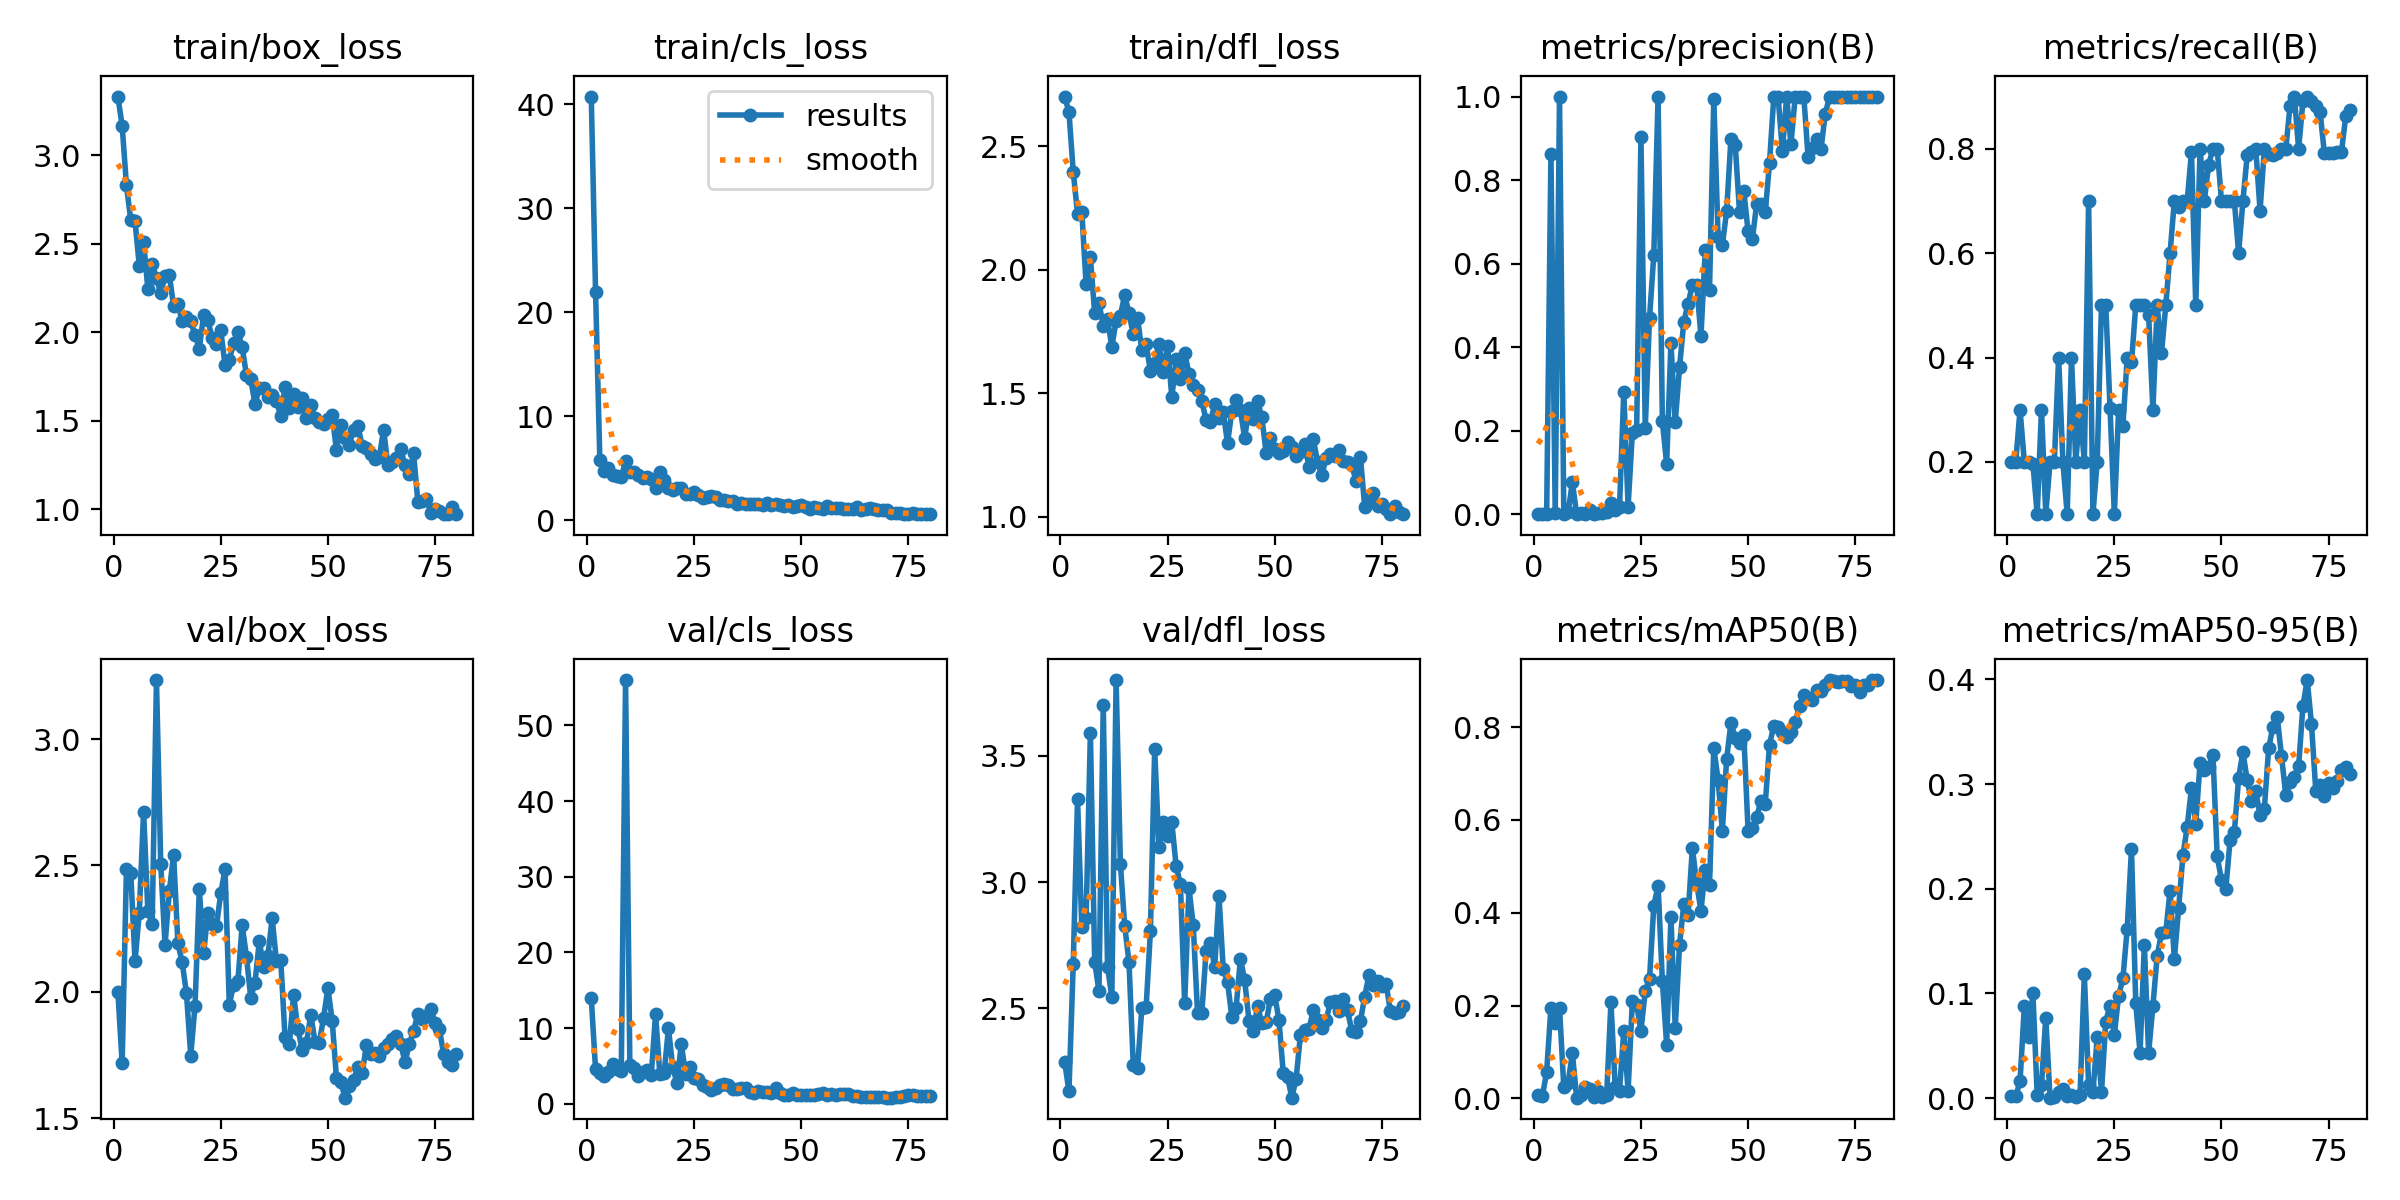

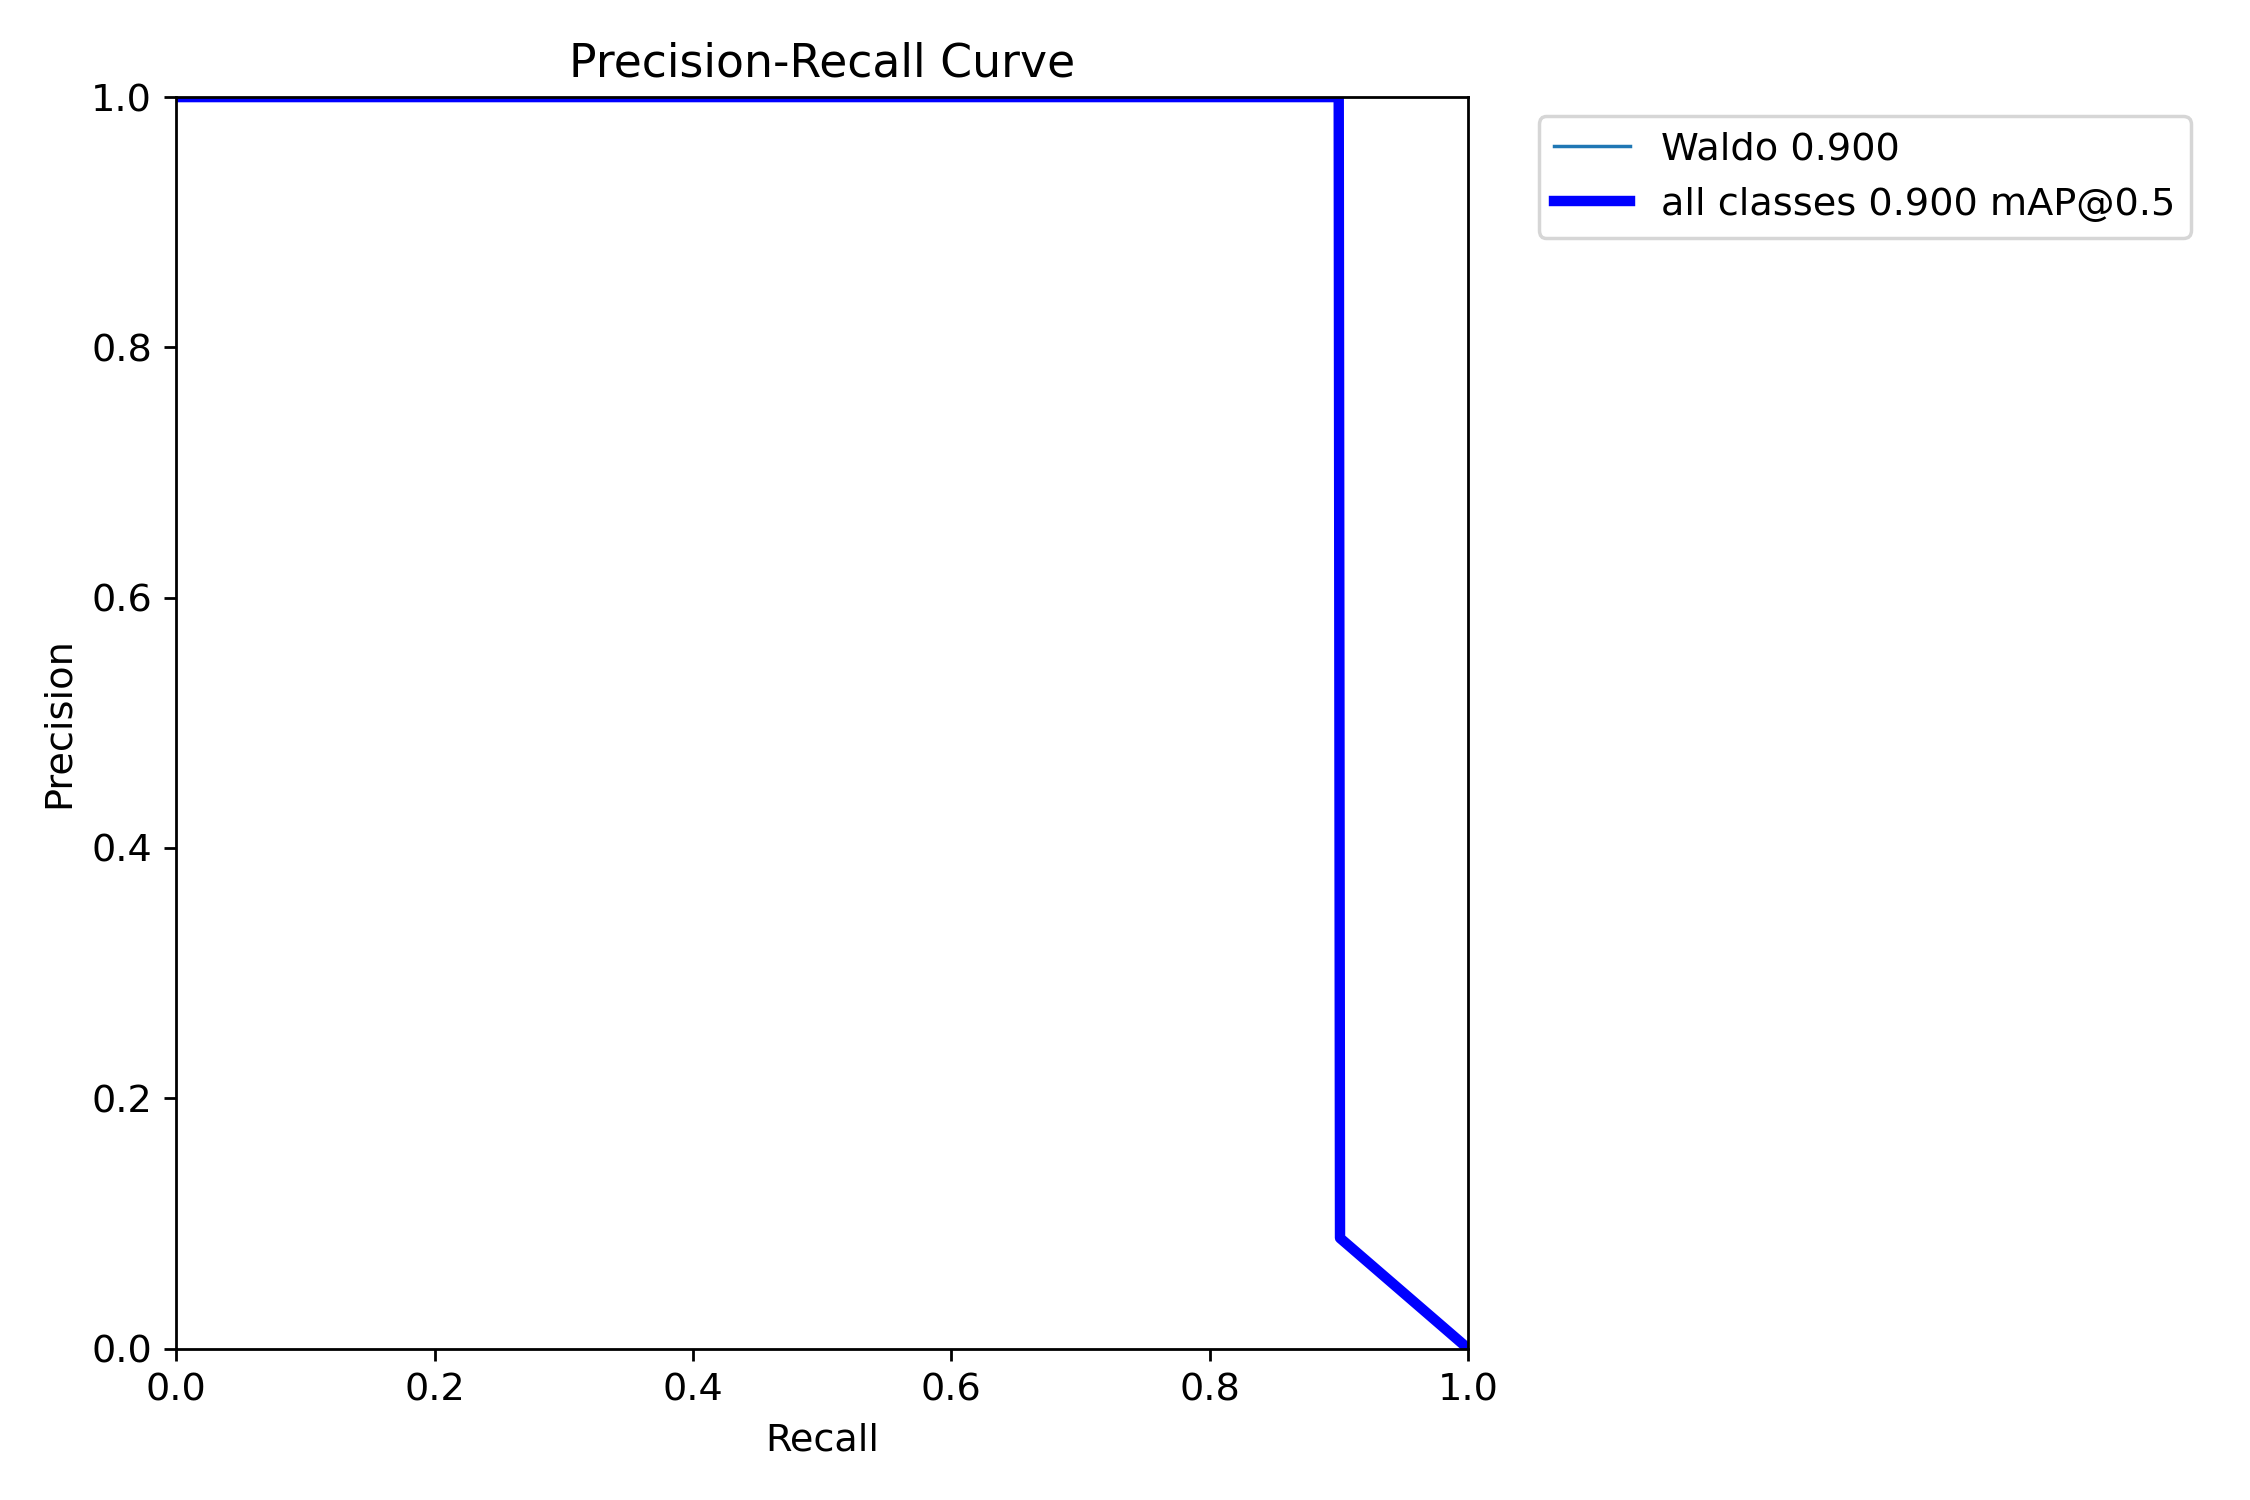

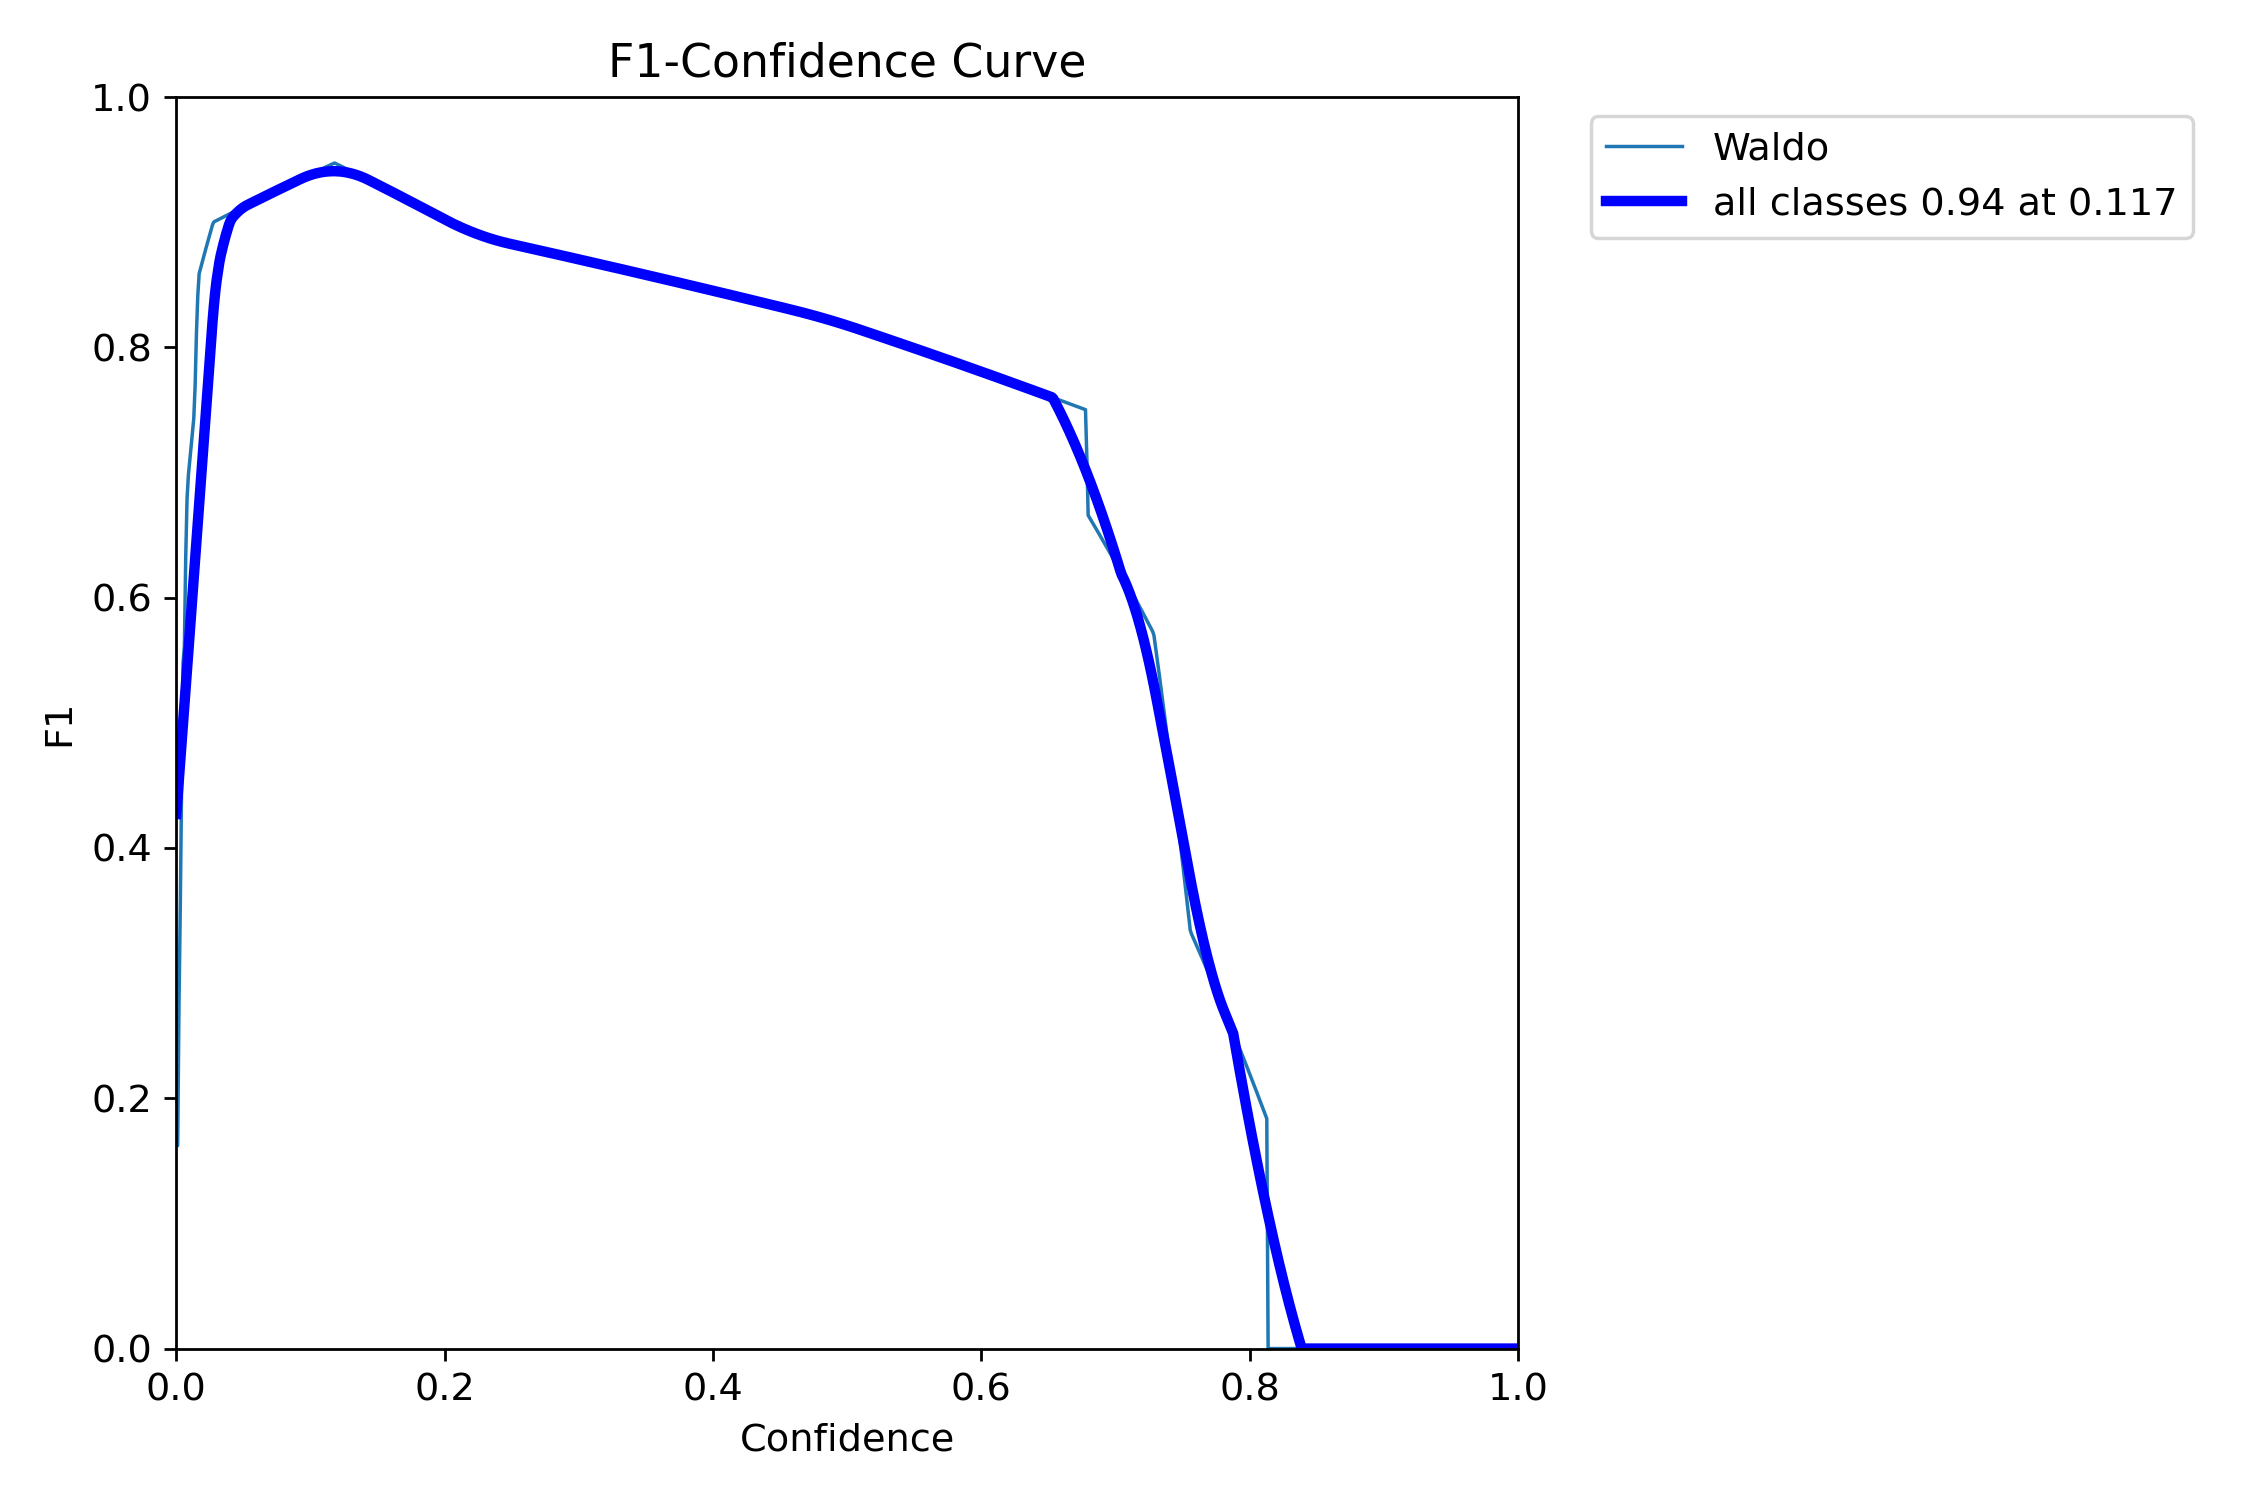

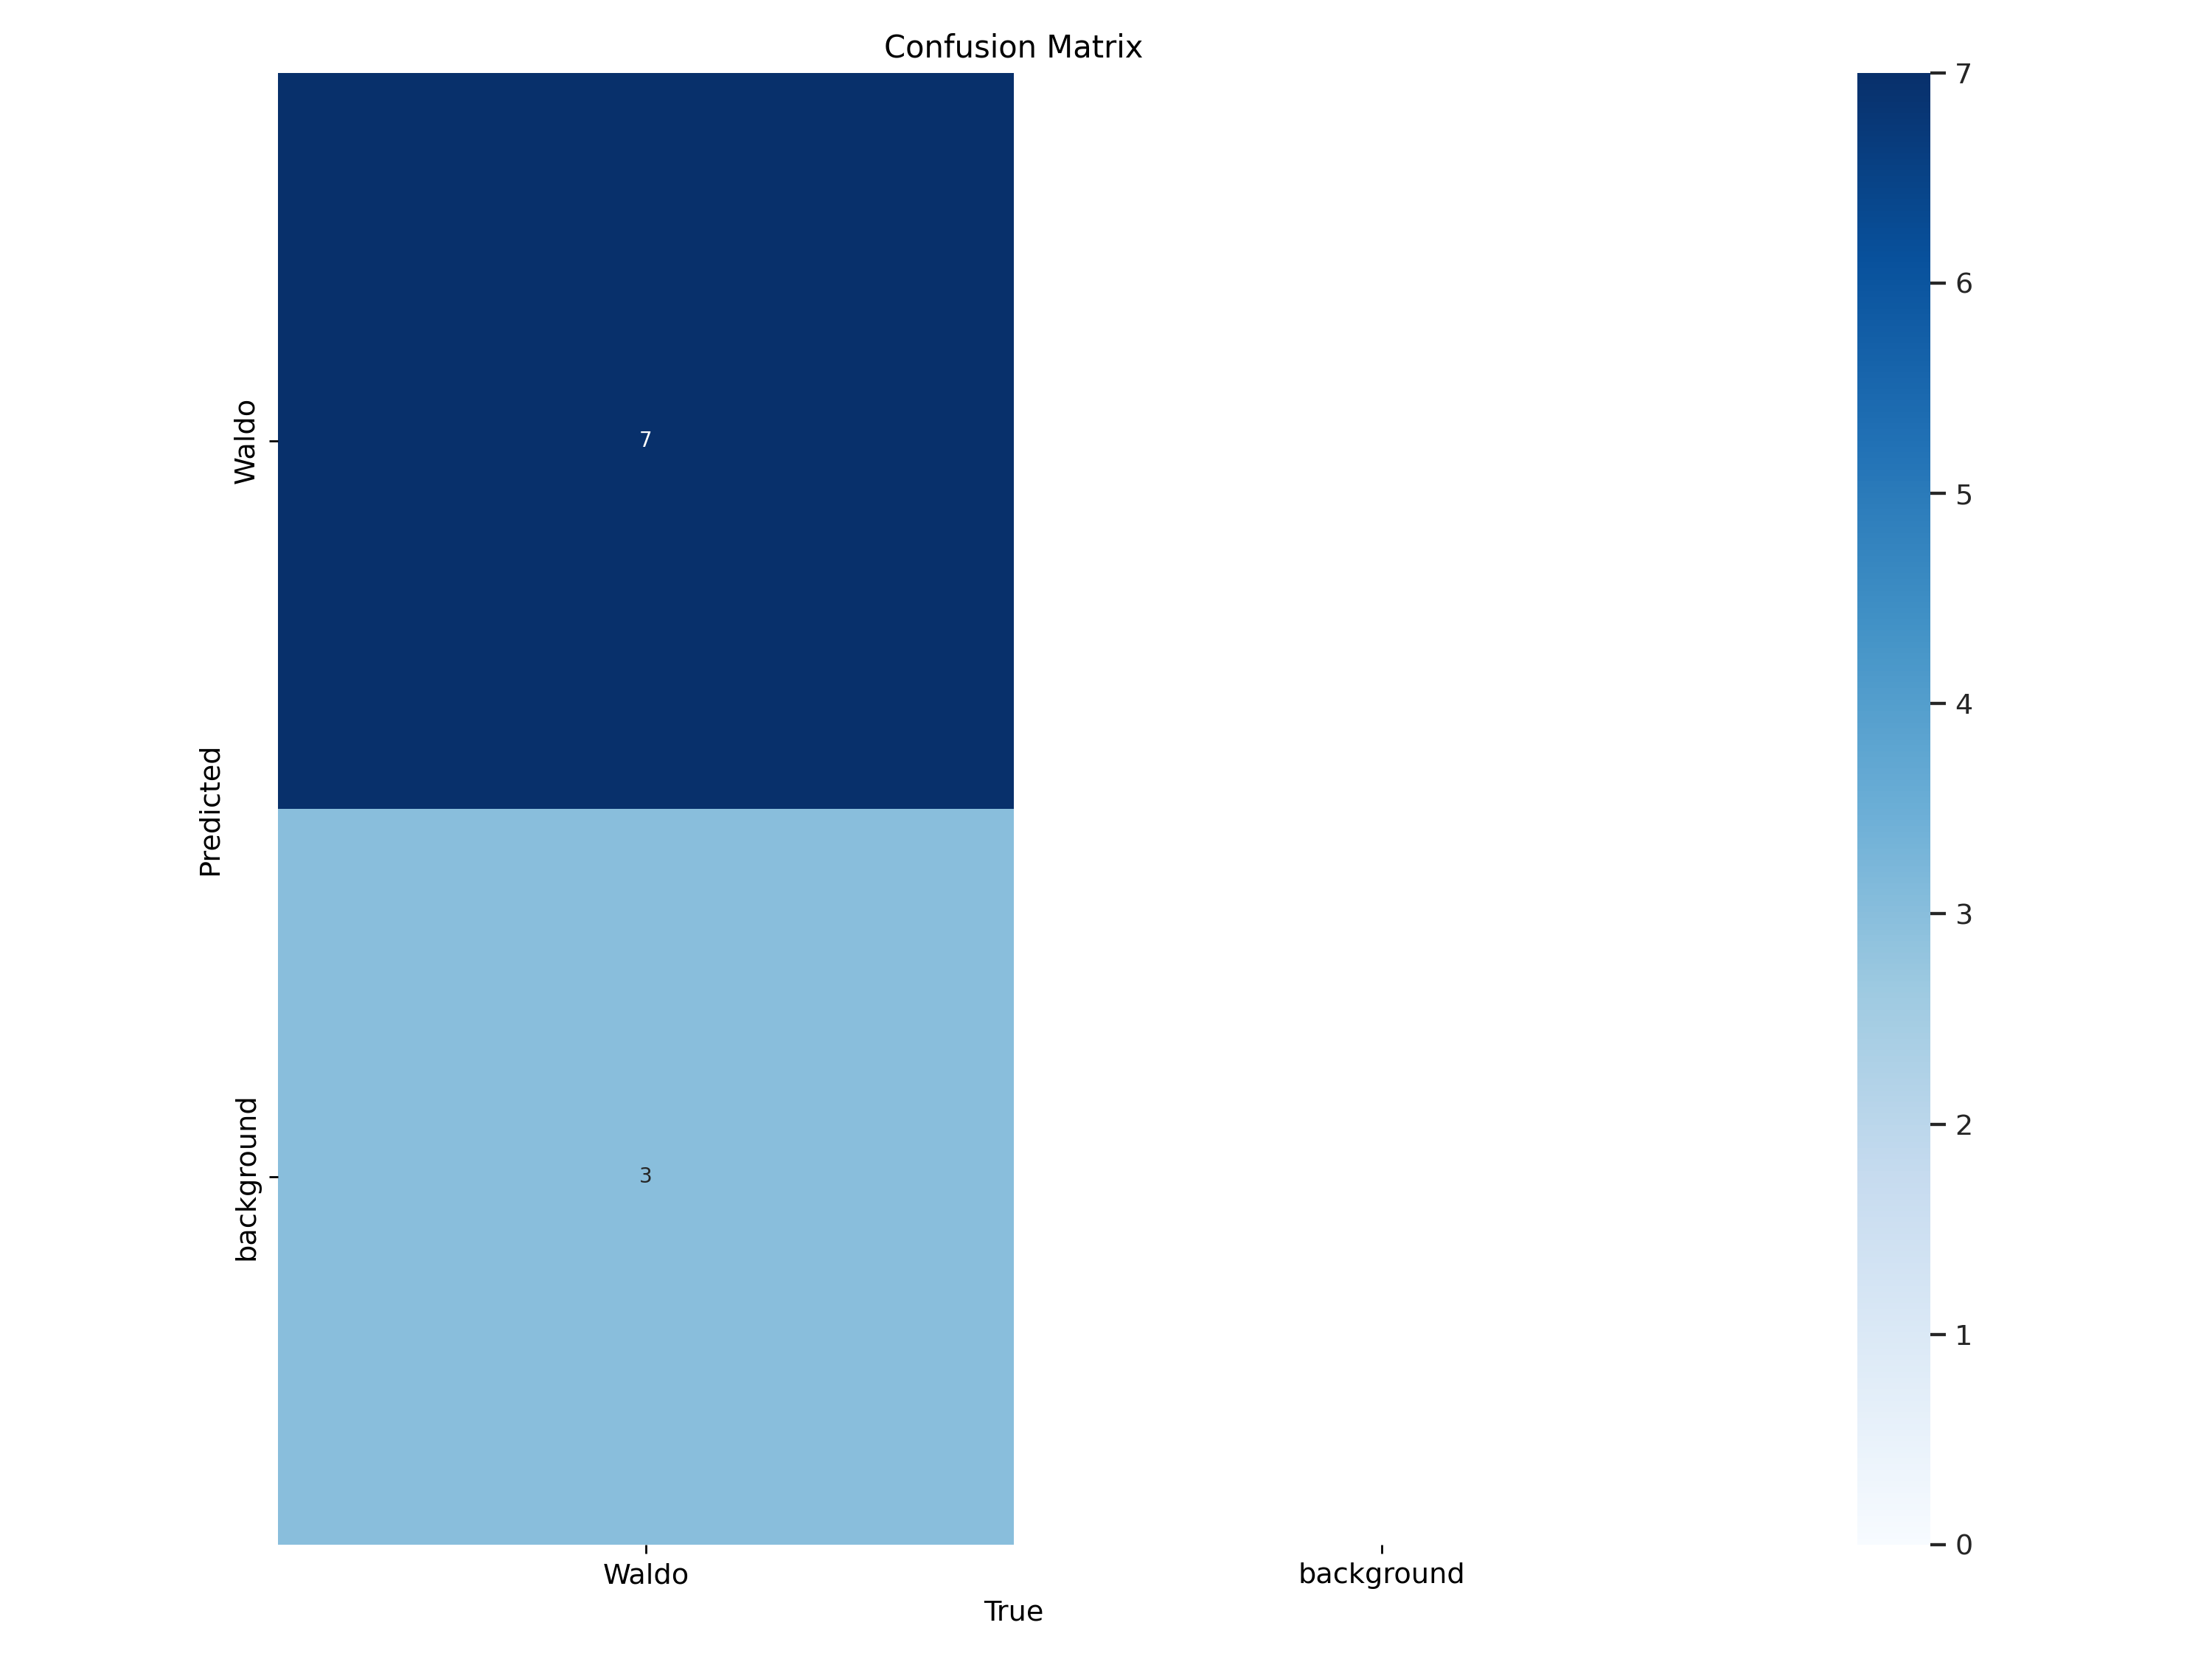

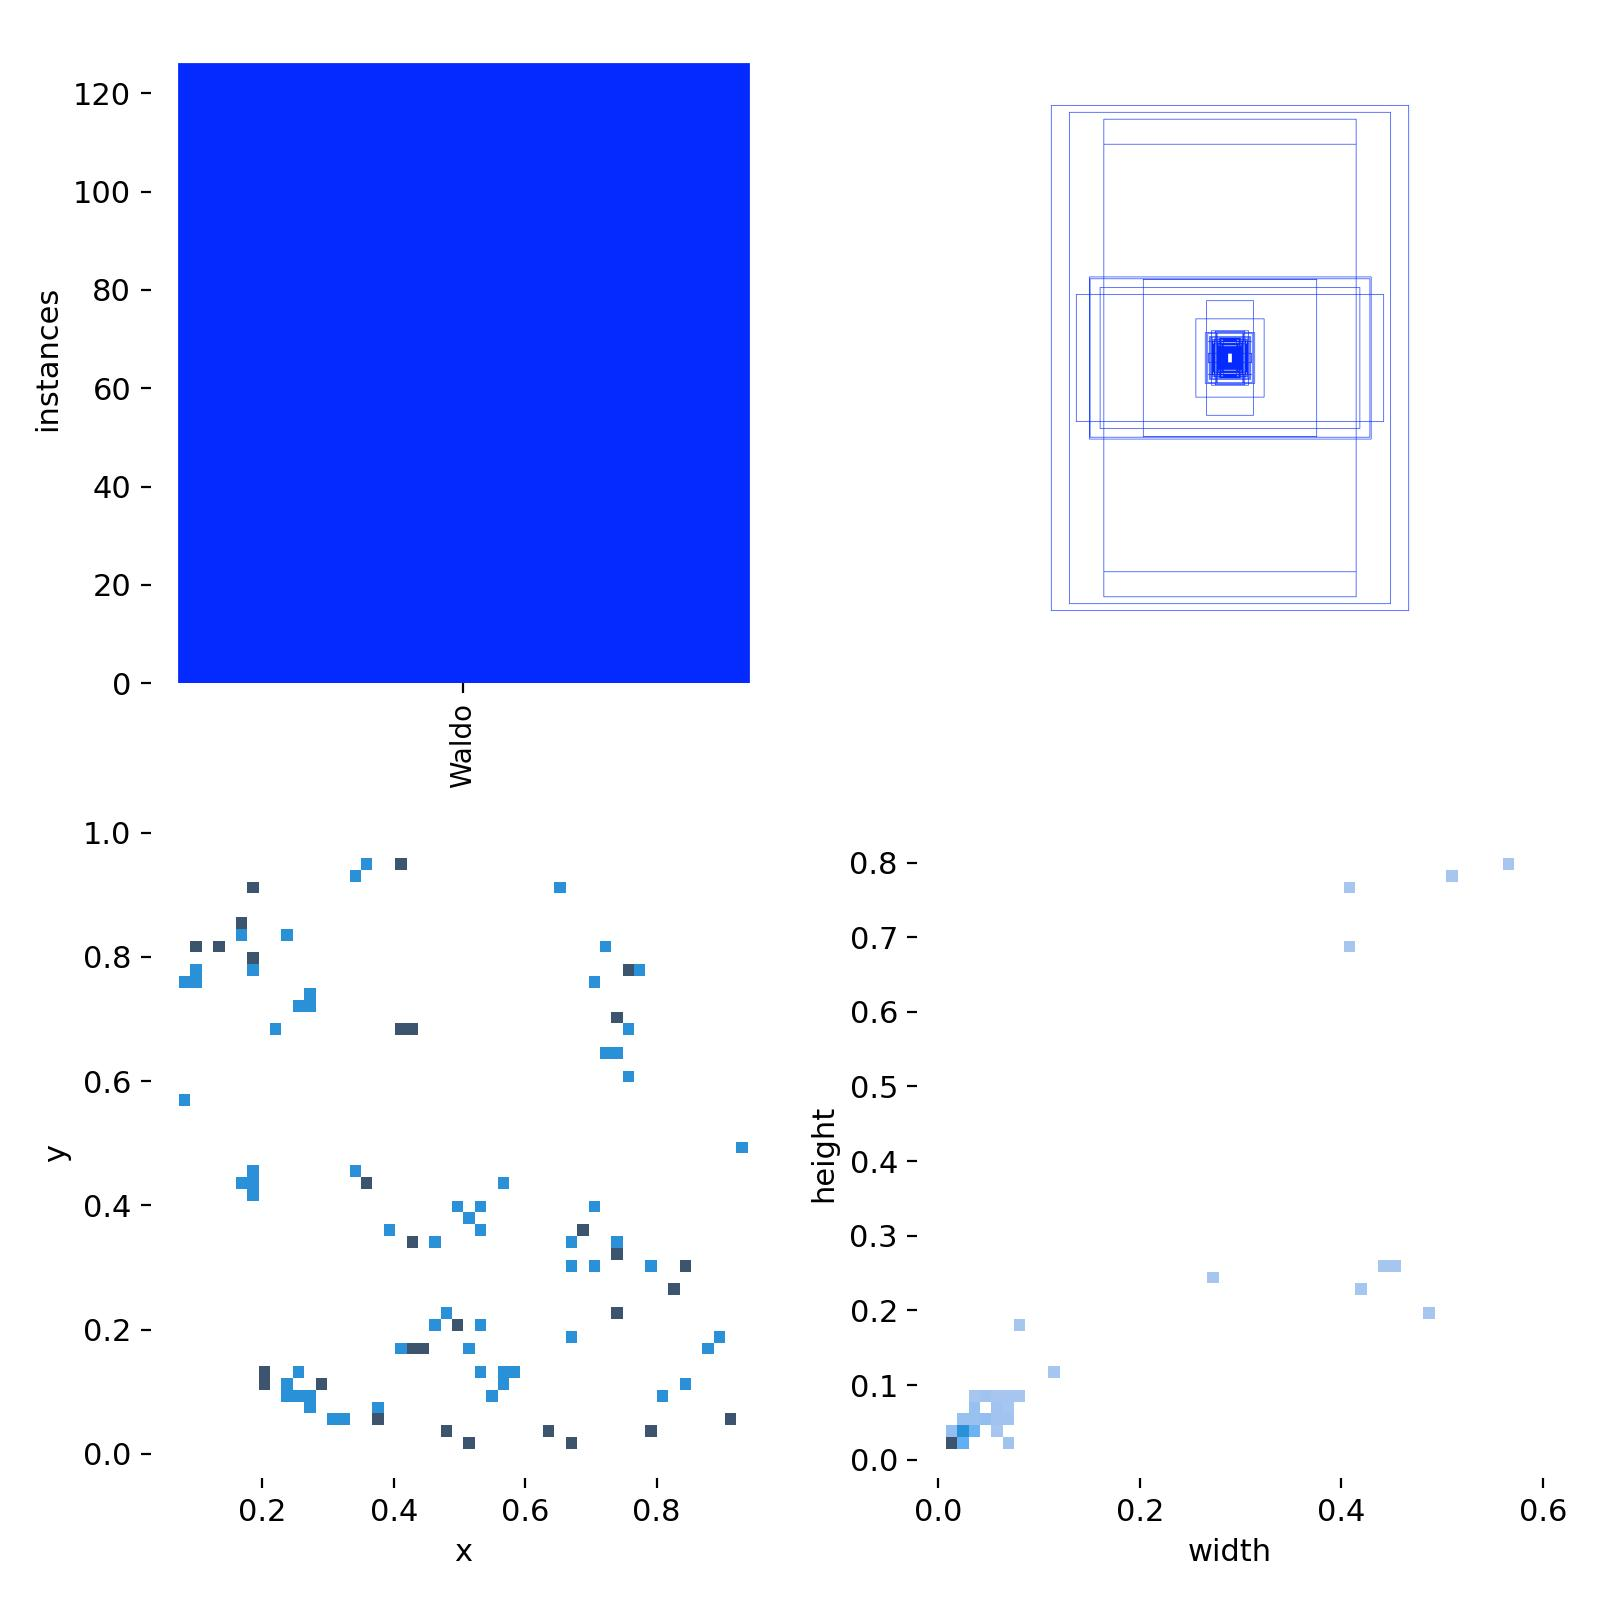

In [6]:
import os
from IPython.display import Image, display

run_dir = 'runs/detect/waldo_1c_y11x_1280'
for f in ['results.png','PR_curve.png','F1_curve.png','confusion_matrix.png','labels.jpg']:
    p = os.path.join(run_dir, f)
    if os.path.exists(p):
        display(Image(filename=p))


## **7. Transfer Learning: Fine-Tuning for Multiple Classes**
This chunk initiates a second training phase, using the previously trained 'Waldo-only' model as a starting point to efficiently train a more complex 4-class detector. This transfer learning approach leverages the features already learned to speed up convergence and improve performance on the new, more challenging dataset.

**Starts from best 1‑class Waldo weights to transfer strong Waldo features to Odlaw, Wilma, and Wizard—while further sharpening Waldo performance via richer negatives and multi‑class separation.**

This second training phase adjusts the strategy for a more complex task while leveraging the knowledge gained from the initial run.

### **Primary Training Settings**
* **Model Initialization**: The training starts from `best_1c`, the best-performing model from the single-class run. This is a key principle of **transfer learning**.
* **Training Duration (`epochs=60`)**: The number of epochs is reduced to 60. Since the model is already partially trained, it requires less time to adapt to the new classes.
* **Batch Size (`batch=max(2, BATCH//2)`)**: The batch size is halved. This is a common adjustment to ensure the training process can fit into the GPU's memory, especially when the model or data complexity increases.
* **Learning Rate (`lr0=0.005`)**: The learning rate is lowered. This is a standard practice for fine-tuning, as it allows the model to make smaller, more precise adjustments to its weights without destroying the previously learned features.

***

### **System & Performance Optimization**
* The configuration for **GPU Acceleration (`device=0`)**, **Data Loading (`workers=2`)**, and **Mixed Precision (`amp=True`)** remains consistent, ensuring an efficient and optimized training environment.

***

### **Advanced Data Augmentation**
* The data augmentation strategy, including **`mosaic`**, **`copy_paste`**, **`mixup`**, and the **`close_mosaic`** technique, is maintained from the previous run. This provides a consistent approach to generating diverse training examples, which is crucial for helping the model distinguish between the four different classes.

In [7]:
from ultralytics import YOLO
free_vram()

model_4c = YOLO(best_1c)
r4 = model_4c.train(
    data='/content/data_4cls.yaml',
    imgsz=IMGSZ,
    epochs=60,
    batch=max(2, BATCH//2),
    lr0=0.005,
    optimizer='SGD',
    device=0,
    workers=WORKERS,
    amp=True,
    mosaic=1.0, copy_paste=0.3, mixup=0.1,
    close_mosaic=10, multi_scale=False,
    project='runs/detect', name='waldo_4c_y11x_1280', exist_ok=True,
)
best_4c = model_4c.ckpt_path
print("4‑class best:", best_4c)


New https://pypi.org/project/ultralytics/8.3.178 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.30 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11x.pt, data=/content/data_4cls.yaml, epochs=60, time=None, patience=100, batch=2, imgsz=1280, save=True, save_period=-1, cache=False, device=0, workers=2, project=runs/detect, name=waldo_4c_y11x_1280, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None

train: Scanning /content/drive/MyDrive/wally_multiclass/train/labels... 396 images, 63 backgrounds, 0 corrupt: 100%|██████████| 396/396 [00:23<00:00, 16.88it/s]


train: New cache created: /content/drive/MyDrive/wally_multiclass/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/wally_multiclass/valid/labels... 56 images, 13 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:12<00:00,  4.42it/s]

val: New cache created: /content/drive/MyDrive/wally_multiclass/valid/labels.cache


Plotting labels to runs/detect/waldo_4c_y11x_1280/labels.jpg... 
optimizer: SGD(lr=0.005, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 2 dataloader workers
Logging results to runs/detect/waldo_4c_y11x_1280
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      34.1G      2.885      18.51      1.851          3       1280: 100%|██████████| 198/198 [00:53<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]

                   all         56         70   0.000134     0.0417    0.00034   0.000218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      16.9G       2.26      6.499       1.49          1       1280: 100%|██████████| 198/198 [00:42<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.72it/s]

                   all         56         70     0.0259      0.564       0.17     0.0988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      32.5G      1.955       4.68       1.28          8       1280: 100%|██████████| 198/198 [00:41<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.96it/s]

                   all         56         70      0.522      0.413      0.277       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      20.4G       1.71      4.411      1.169          4       1280: 100%|██████████| 198/198 [00:40<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.11it/s]

                   all         56         70      0.215      0.281      0.264      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      28.3G      1.637      3.237      1.134          2       1280: 100%|██████████| 198/198 [00:41<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.02it/s]

                   all         56         70      0.303      0.575      0.451      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      27.9G      1.491      2.582      1.112          3       1280: 100%|██████████| 198/198 [00:41<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.98it/s]

                   all         56         70      0.687      0.458      0.576      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      34.2G      1.415      1.983      1.083          5       1280: 100%|██████████| 198/198 [00:39<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.97it/s]

                   all         56         70      0.593      0.573      0.612      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      13.1G      1.334      1.702       1.03          8       1280: 100%|██████████| 198/198 [00:40<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.69it/s]

                   all         56         70      0.785      0.694      0.704      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      32.5G      1.355      1.594      1.064          4       1280: 100%|██████████| 198/198 [00:38<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.83it/s]

                   all         56         70      0.588      0.312      0.391      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      35.8G      1.294      1.395      1.044          2       1280: 100%|██████████| 198/198 [00:39<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.91it/s]

                   all         56         70      0.661      0.654       0.64       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      16.7G      1.295      1.429       1.03          6       1280: 100%|██████████| 198/198 [00:40<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.89it/s]

                   all         56         70      0.757      0.732      0.774      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      23.2G      1.238      1.247      1.026          2       1280: 100%|██████████| 198/198 [00:42<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.76it/s]

                   all         56         70      0.754      0.715      0.783      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      22.5G      1.237      1.186      1.018          2       1280: 100%|██████████| 198/198 [00:42<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.03it/s]

                   all         56         70      0.789      0.644      0.725      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      10.4G      1.188      1.066      1.002          5       1280: 100%|██████████| 198/198 [00:42<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.79it/s]

                   all         56         70      0.721      0.703      0.741       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      34.7G      1.196      1.122     0.9752          2       1280: 100%|██████████| 198/198 [00:41<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.01it/s]

                   all         56         70      0.804      0.614      0.762      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      17.1G       1.12     0.9892     0.9652          6       1280: 100%|██████████| 198/198 [00:39<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.79it/s]

                   all         56         70      0.739      0.654      0.732      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60        23G      1.154     0.9571     0.9623          4       1280: 100%|██████████| 198/198 [00:41<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.92it/s]

                   all         56         70       0.79       0.72      0.758      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      41.8G      1.077     0.8969     0.9678          1       1280: 100%|██████████| 198/198 [00:42<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.73it/s]

                   all         56         70      0.845      0.617      0.743      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      41.8G      1.071     0.9548     0.9688          2       1280: 100%|██████████| 198/198 [00:42<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.97it/s]

                   all         56         70      0.822      0.727      0.802       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      17.3G      1.032     0.9049     0.9169          3       1280: 100%|██████████| 198/198 [00:38<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.97it/s]

                   all         56         70      0.864      0.714      0.789      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      23.7G      1.069     0.8837     0.9354          8       1280: 100%|██████████| 198/198 [00:41<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.16it/s]

                   all         56         70      0.865      0.738      0.825      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60        32G      1.007     0.7917     0.9201          3       1280: 100%|██████████| 198/198 [00:39<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.09it/s]

                   all         56         70      0.961      0.633      0.782      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      36.5G      1.052     0.8922     0.9584          2       1280: 100%|██████████| 198/198 [00:40<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.08it/s]

                   all         56         70      0.896      0.705      0.812      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      13.8G       1.01     0.8406      0.892          3       1280: 100%|██████████| 198/198 [00:39<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.84it/s]

                   all         56         70       0.96      0.687      0.827      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60        26G     0.9444     0.7696     0.8893          1       1280: 100%|██████████| 198/198 [00:38<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.99it/s]

                   all         56         70      0.876      0.762      0.846      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      33.4G     0.9553     0.8388     0.8995          3       1280: 100%|██████████| 198/198 [00:42<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.97it/s]

                   all         56         70      0.812      0.838      0.864      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      38.9G     0.9018     0.6794     0.8899          6       1280: 100%|██████████| 198/198 [00:42<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  9.92it/s]

                   all         56         70      0.927      0.749      0.852      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      16.7G     0.9845     0.8553     0.9195          5       1280: 100%|██████████| 198/198 [00:42<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.88it/s]

                   all         56         70      0.858       0.76      0.801      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      22.2G     0.8929     0.6366     0.9052          3       1280: 100%|██████████| 198/198 [00:42<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.83it/s]

                   all         56         70      0.916      0.751      0.861      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      27.7G     0.8932      0.736     0.9098          5       1280: 100%|██████████| 198/198 [00:42<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.95it/s]

                   all         56         70      0.951      0.781      0.855      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      10.4G     0.9348      0.731      0.909          5       1280: 100%|██████████| 198/198 [00:38<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.80it/s]

                   all         56         70       0.87      0.812      0.862      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      10.4G     0.9086     0.7729     0.9105          3       1280: 100%|██████████| 198/198 [00:42<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.80it/s]

                   all         56         70      0.839      0.832      0.842      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      27.7G     0.8292     0.5924     0.8732          6       1280: 100%|██████████| 198/198 [00:42<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.09it/s]

                   all         56         70      0.911      0.735      0.846       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      10.1G     0.8663     0.6598     0.9078          7       1280: 100%|██████████| 198/198 [00:41<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.88it/s]

                   all         56         70      0.807      0.721      0.826      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      25.3G     0.8251     0.6281     0.8556          3       1280: 100%|██████████| 198/198 [00:38<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.17it/s]

                   all         56         70      0.895      0.675      0.805      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      36.3G     0.8187      0.683     0.8586          2       1280: 100%|██████████| 198/198 [00:39<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.09it/s]

                   all         56         70      0.822      0.767      0.862      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      10.4G     0.7751     0.5936     0.8554          8       1280: 100%|██████████| 198/198 [00:42<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.96it/s]

                   all         56         70      0.906      0.804       0.89      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      10.3G     0.7496     0.6179     0.8496          1       1280: 100%|██████████| 198/198 [00:42<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.65it/s]

                   all         56         70      0.909      0.848      0.915      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      37.9G     0.7601     0.5668     0.8568          2       1280: 100%|██████████| 198/198 [00:40<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.09it/s]

                   all         56         70      0.882      0.781      0.882      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      15.8G     0.7795     0.5776     0.8431          4       1280: 100%|██████████| 198/198 [00:41<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.91it/s]

                   all         56         70      0.912      0.736      0.866      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      15.3G     0.7993     0.6127     0.8705          3       1280: 100%|██████████| 198/198 [00:41<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.89it/s]

                   all         56         70      0.874      0.766      0.859      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      10.4G     0.7696     0.6067     0.8674          2       1280: 100%|██████████| 198/198 [00:41<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.87it/s]

                   all         56         70       0.88      0.769      0.865      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      10.3G     0.7458     0.5444     0.8689          5       1280: 100%|██████████| 198/198 [00:40<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.74it/s]

                   all         56         70      0.908      0.773      0.854      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      29.8G     0.7215     0.5371     0.8342          1       1280: 100%|██████████| 198/198 [00:41<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.10it/s]

                   all         56         70      0.886      0.787      0.883      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      27.5G     0.7521     0.6497     0.8911          3       1280: 100%|██████████| 198/198 [00:41<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.01it/s]

                   all         56         70      0.887       0.83      0.887      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      37.5G     0.7262     0.5249     0.8707          1       1280: 100%|██████████| 198/198 [00:43<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.89it/s]

                   all         56         70      0.957        0.7      0.873      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      10.2G     0.7588     0.5306      0.866          1       1280: 100%|██████████| 198/198 [00:40<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.95it/s]

                   all         56         70      0.934      0.771      0.882        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      16.2G      0.689     0.5111     0.8566          3       1280: 100%|██████████| 198/198 [00:41<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.10it/s]

                   all         56         70      0.957        0.8       0.88      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      36.5G      0.699     0.5303     0.8359          5       1280: 100%|██████████| 198/198 [00:42<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.20it/s]

                   all         56         70       0.92      0.799      0.885      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      23.6G     0.6239     0.4958     0.7849          2       1280: 100%|██████████| 198/198 [00:42<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.81it/s]

                   all         56         70      0.906       0.83      0.889      0.505


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      39.1G     0.5252     0.3594     0.7453          0       1280: 100%|██████████| 198/198 [00:42<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.11it/s]

                   all         56         70       0.91      0.804      0.874      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      40.6G      0.583     0.3924     0.8098          2       1280: 100%|██████████| 198/198 [00:41<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.27it/s]

                   all         56         70      0.907      0.798      0.871      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      16.6G     0.5584      0.381     0.8094          3       1280: 100%|██████████| 198/198 [00:41<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.05it/s]

                   all         56         70      0.914      0.807      0.874      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60        13G      0.527     0.3355     0.7692          2       1280: 100%|██████████| 198/198 [00:41<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.96it/s]

                   all         56         70      0.955      0.791      0.882      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      23.9G     0.5492     0.3652     0.7954          5       1280: 100%|██████████| 198/198 [00:40<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.95it/s]

                   all         56         70      0.951      0.794      0.878      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      32.3G     0.5156     0.3548      0.764          3       1280: 100%|██████████| 198/198 [00:39<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.00it/s]

                   all         56         70      0.938      0.808      0.875      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      10.4G     0.5367     0.3324     0.8094          4       1280: 100%|██████████| 198/198 [00:39<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.82it/s]

                   all         56         70      0.941        0.8      0.877      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      10.9G     0.5065     0.3448      0.798          2       1280: 100%|██████████| 198/198 [00:40<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 10.92it/s]

                   all         56         70       0.97      0.794      0.874      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      38.3G     0.5058     0.3224     0.7875          4       1280: 100%|██████████| 198/198 [00:39<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.25it/s]

                   all         56         70      0.955      0.798      0.876      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      13.2G     0.4994     0.3344     0.7783          1       1280: 100%|██████████| 198/198 [00:40<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00, 11.03it/s]

                   all         56         70      0.966      0.778      0.872      0.507



60 epochs completed in 0.741 hours.
Optimizer stripped from runs/detect/waldo_4c_y11x_1280/weights/last.pt, 114.5MB
Optimizer stripped from runs/detect/waldo_4c_y11x_1280/weights/best.pt, 114.5MB

Validating runs/detect/waldo_4c_y11x_1280/weights/best.pt...
Ultralytics 8.3.30 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11x summary (fused): 464 layers, 56,831,644 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.45it/s]


                   all         56         70      0.955      0.791      0.882      0.524
                 Odlaw         18         18      0.958      0.778      0.855      0.518
                 Waldo         18         18          1      0.679      0.867      0.478
                 Wilma         18         18      0.886      0.833      0.864      0.548
                Wizard         16         16      0.978      0.875      0.941      0.551
Speed: 0.6ms preprocess, 16.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/waldo_4c_y11x_1280
4‑class best: yolo11x.pt


## **8. Visualize 4-Class Model Performance**
Renders the key performance metrics and diagnostic plots from the multi-class training run to evaluate its effectiveness.

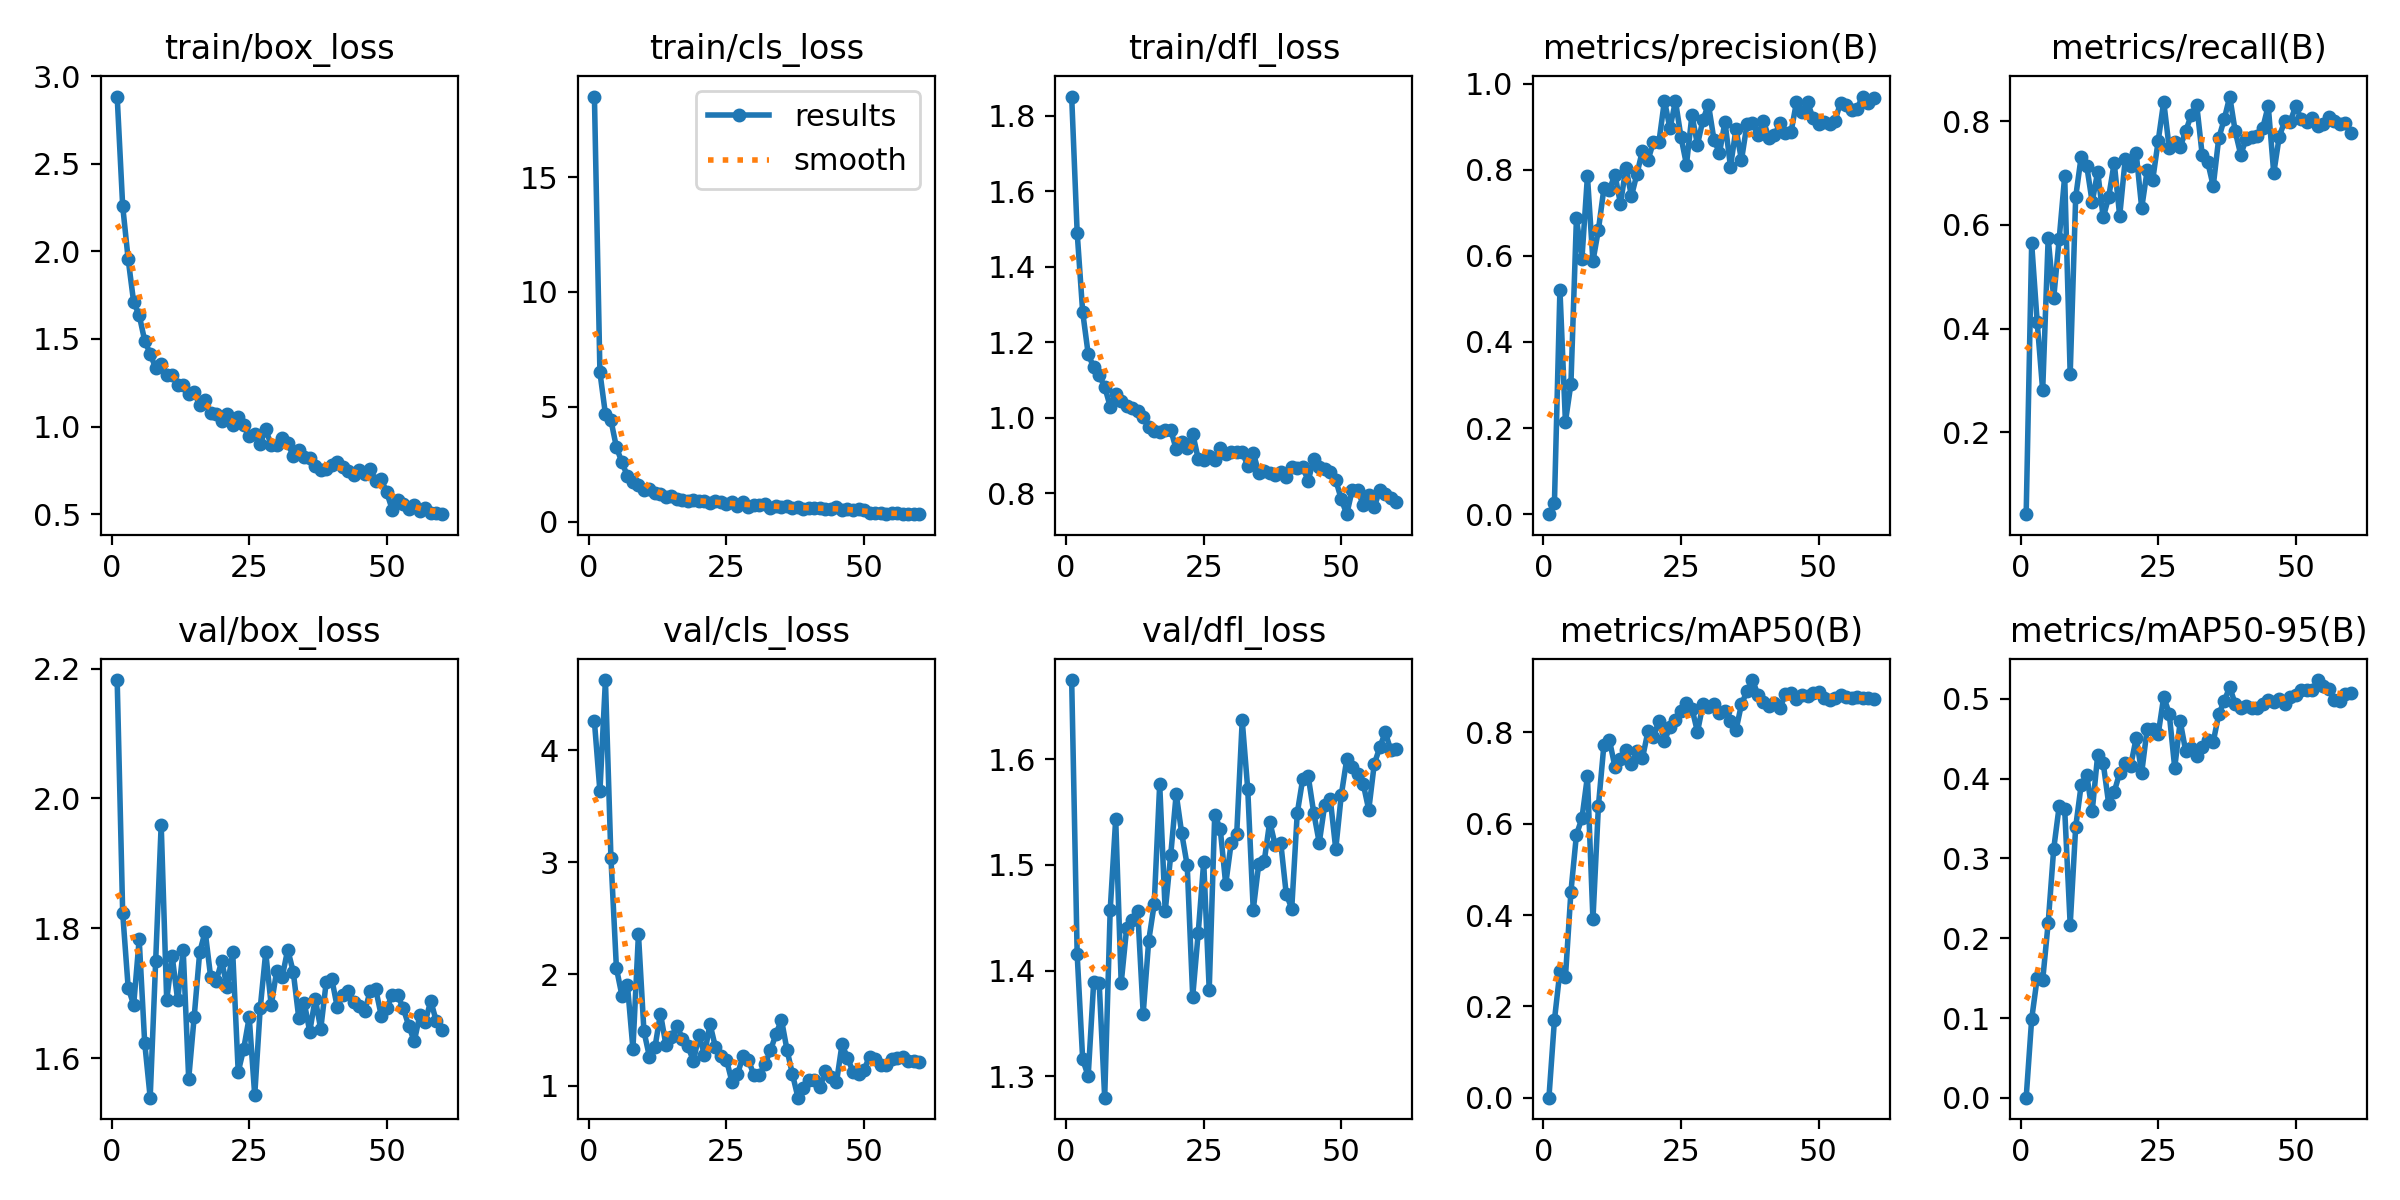

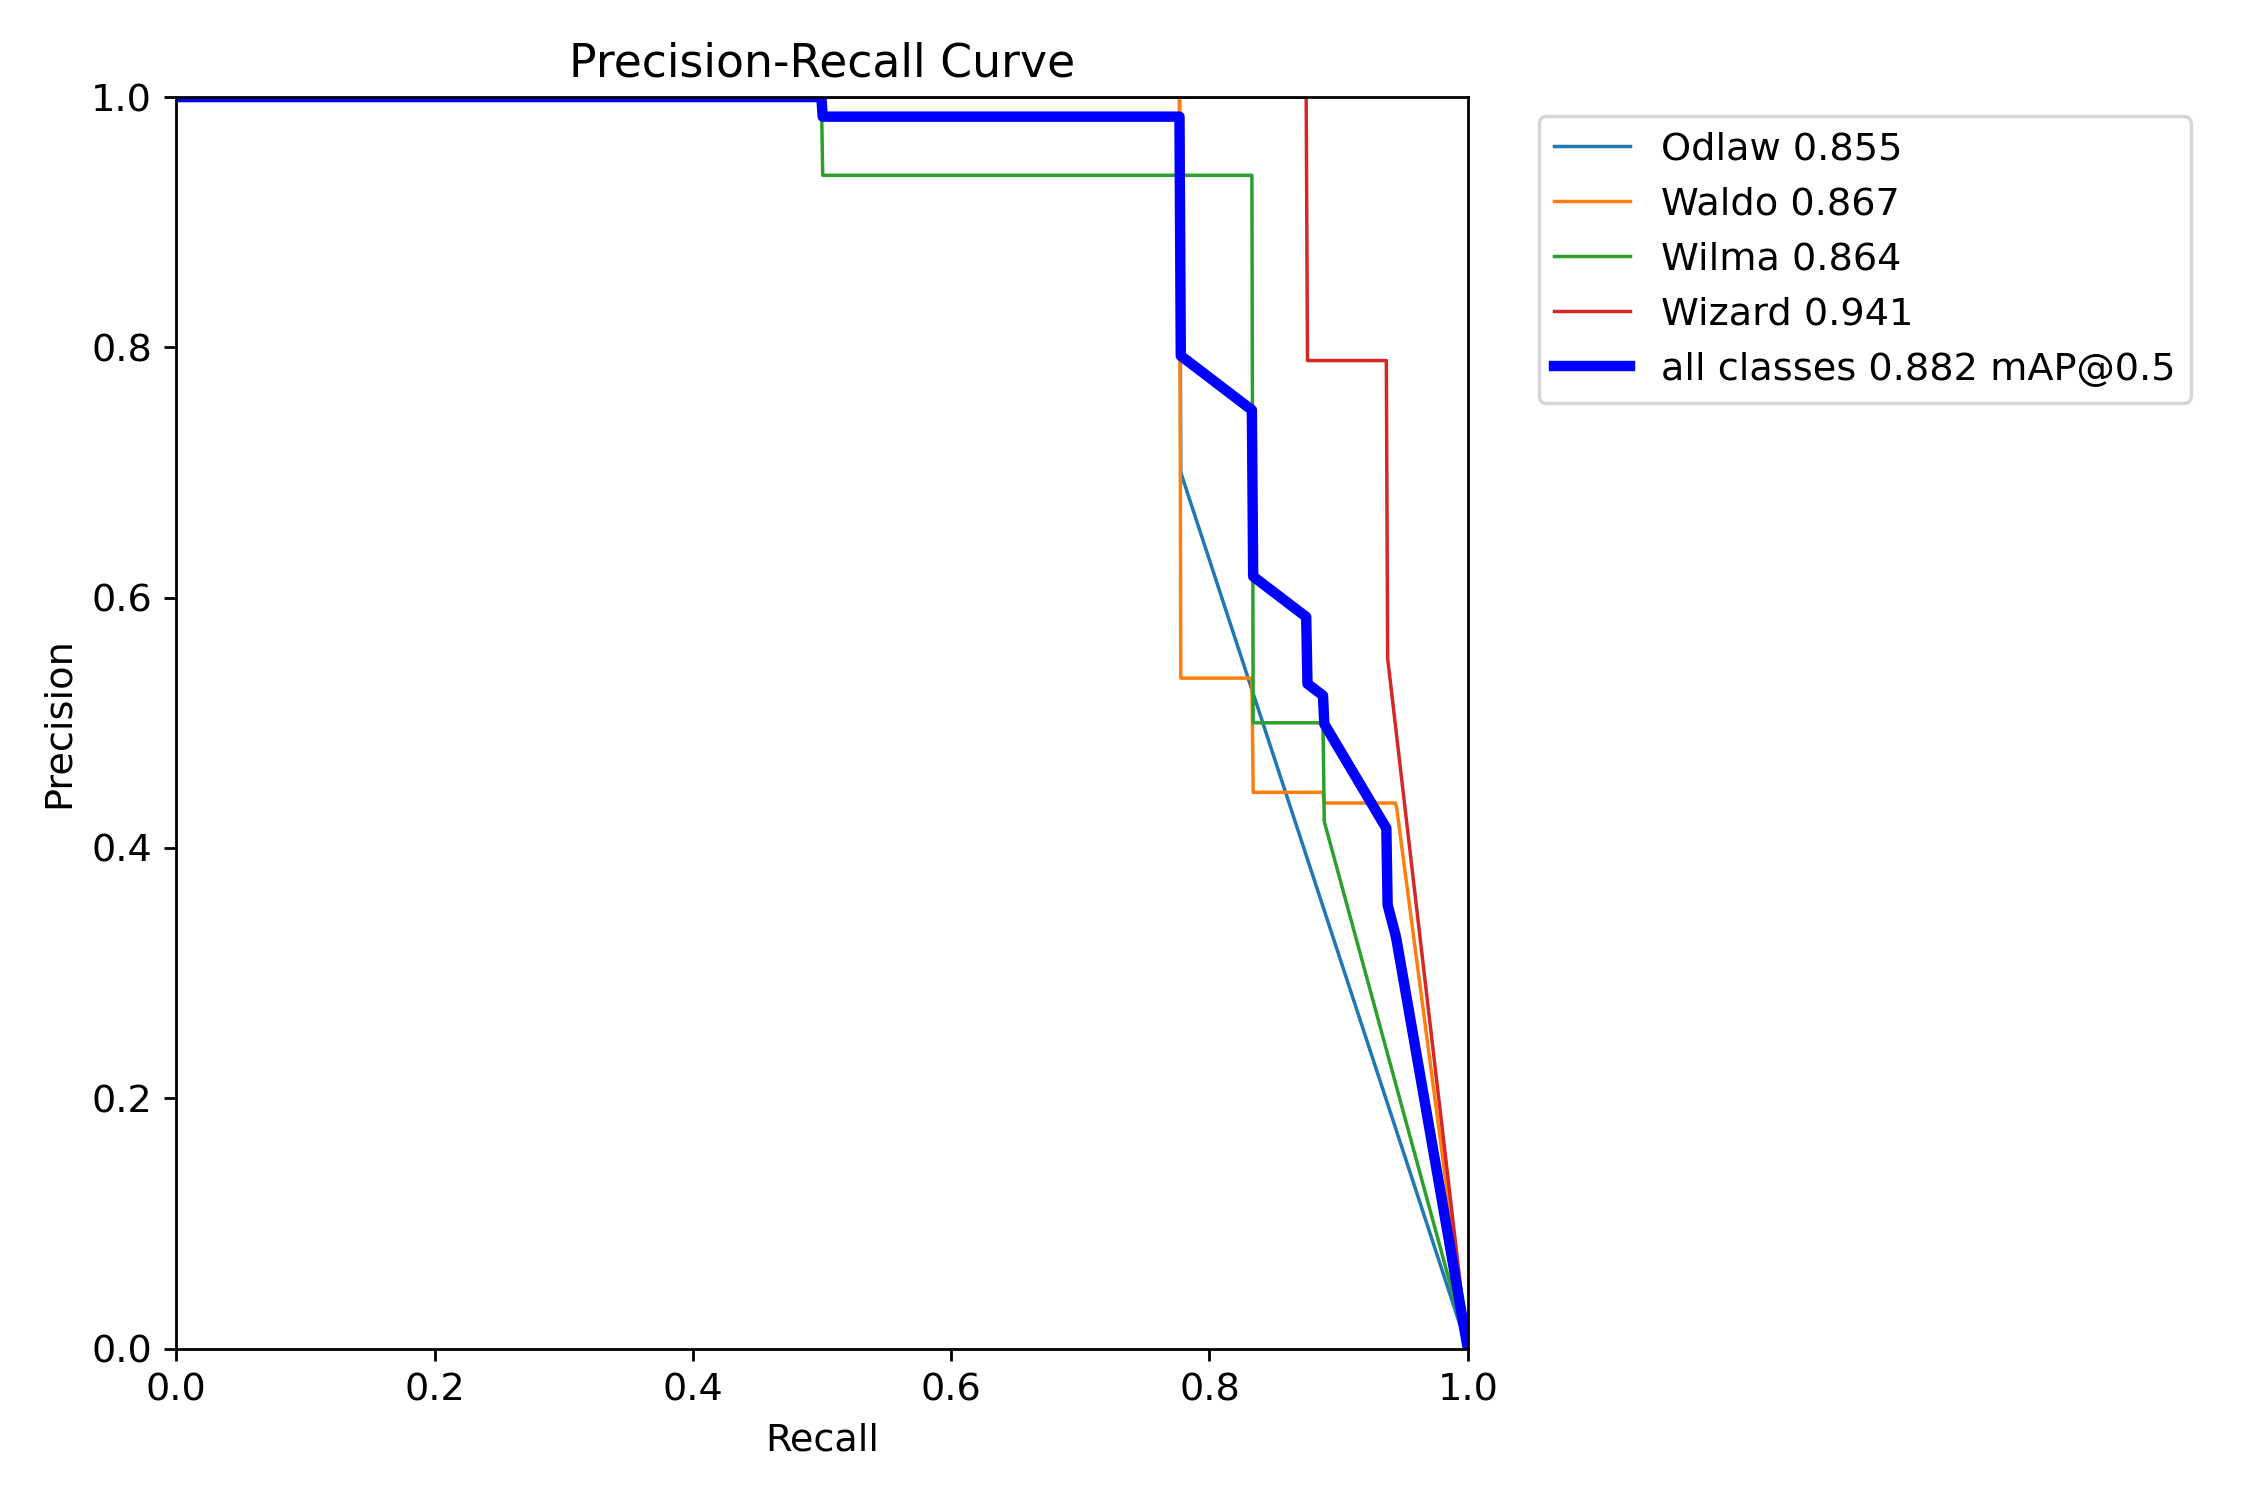

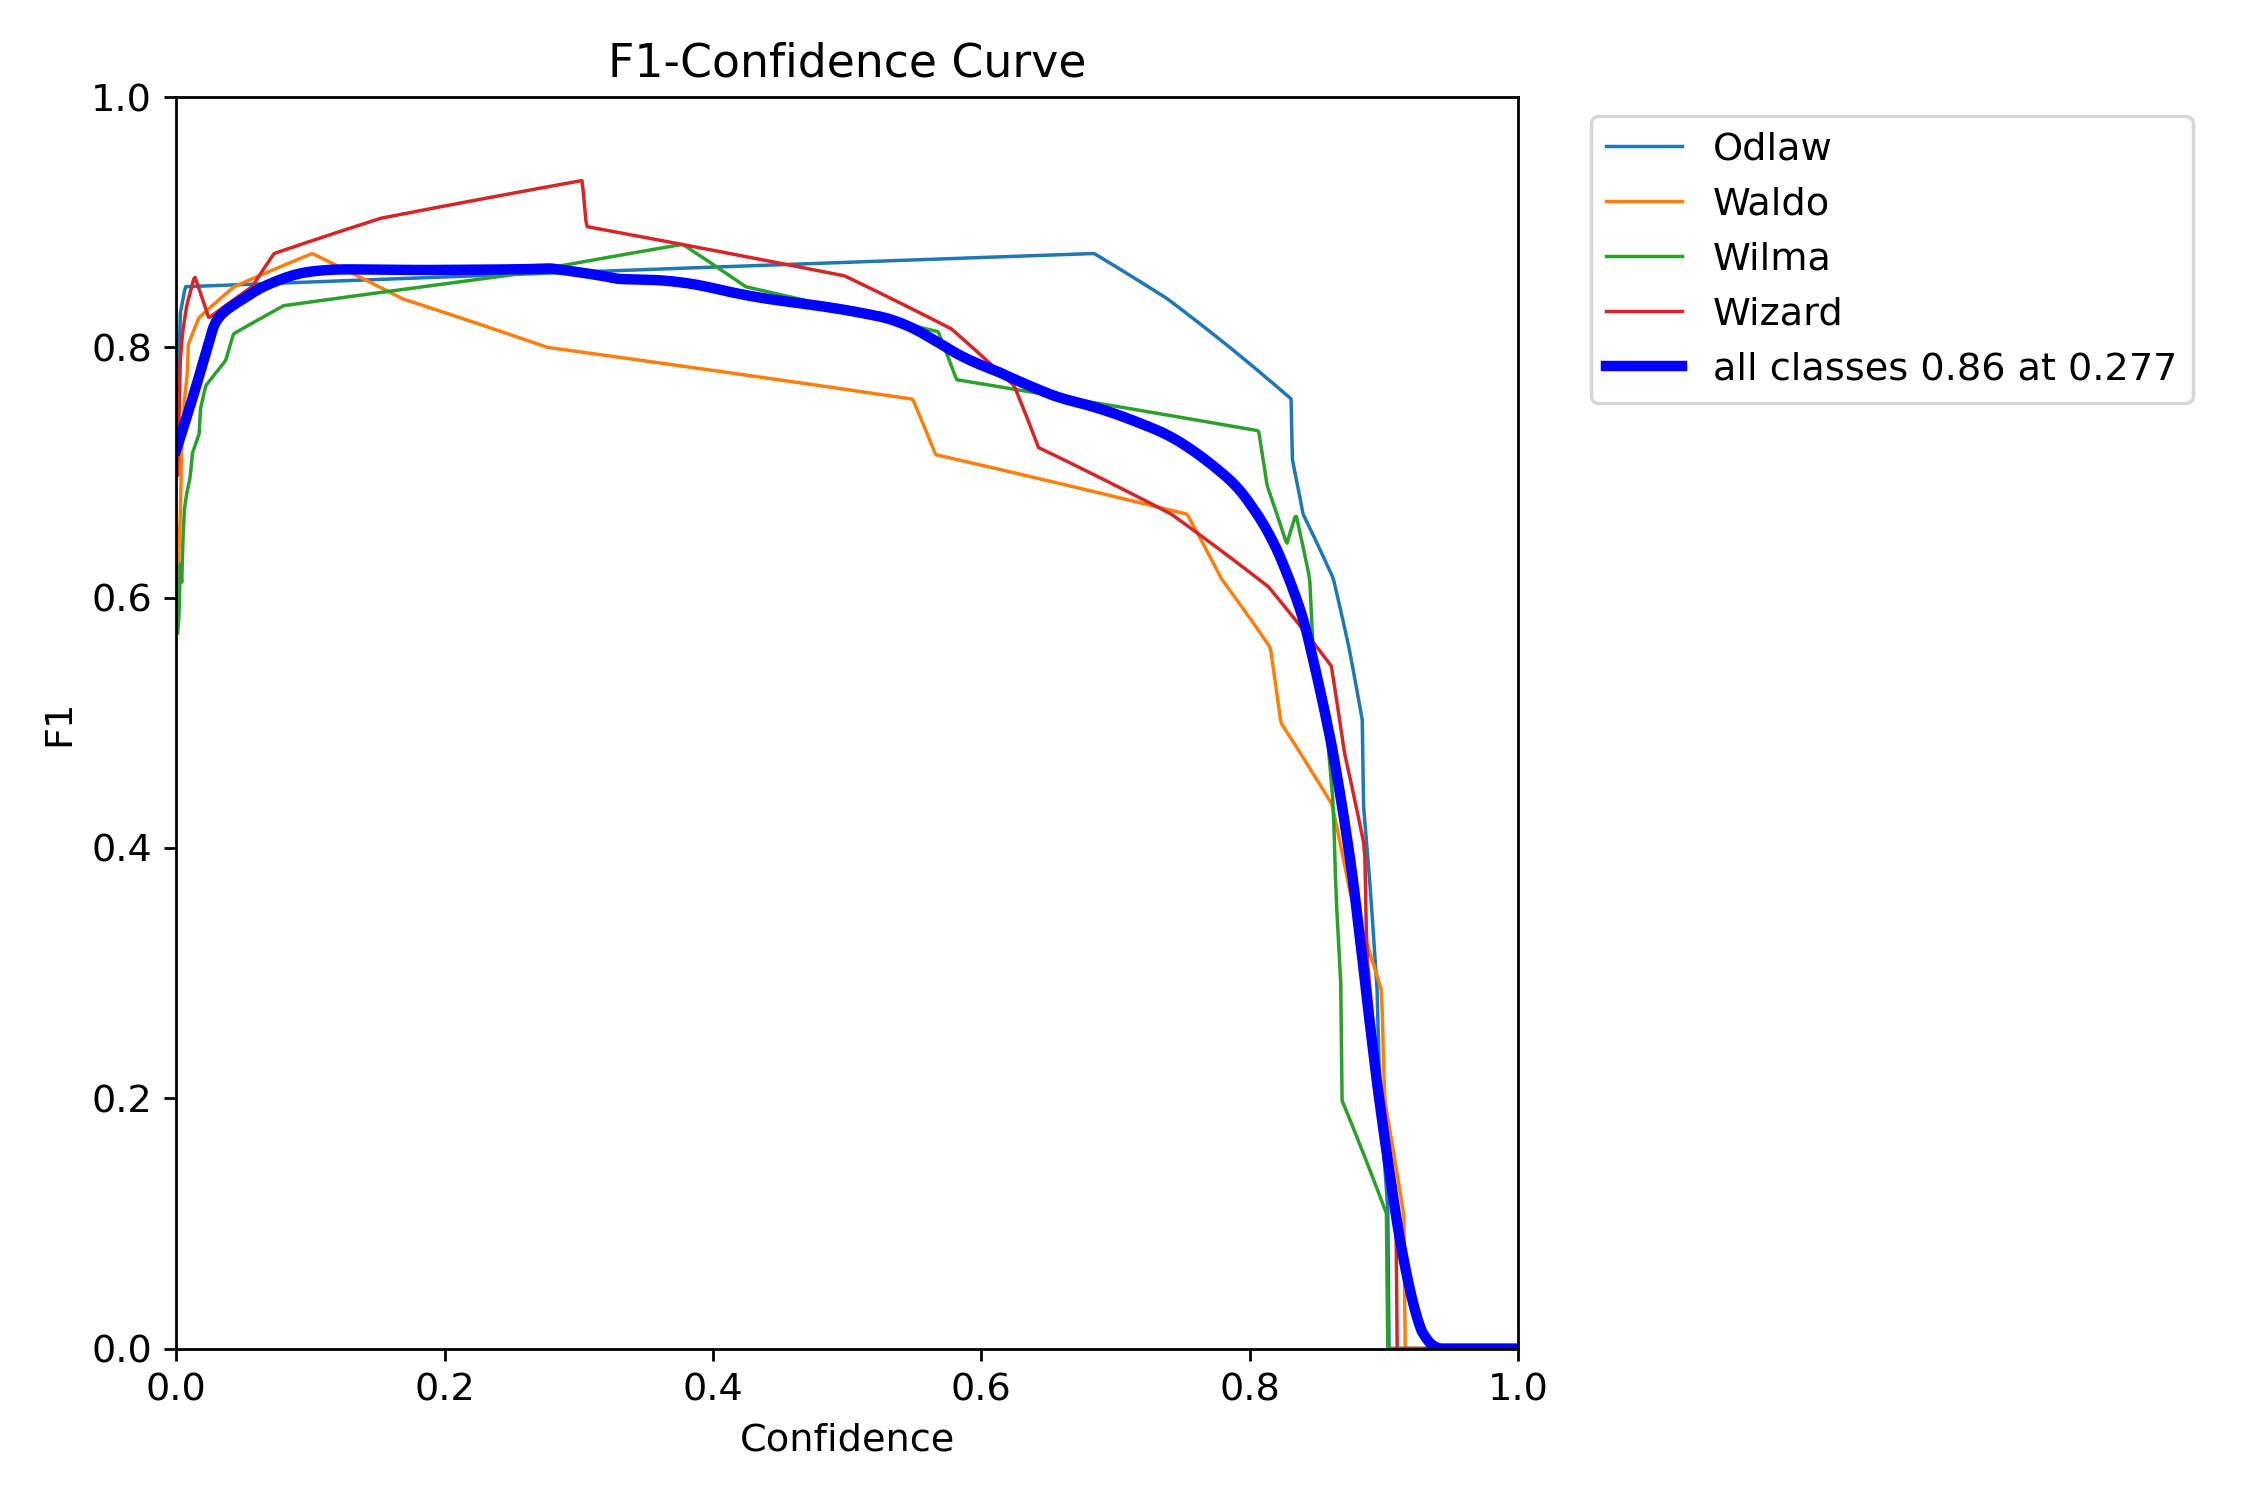

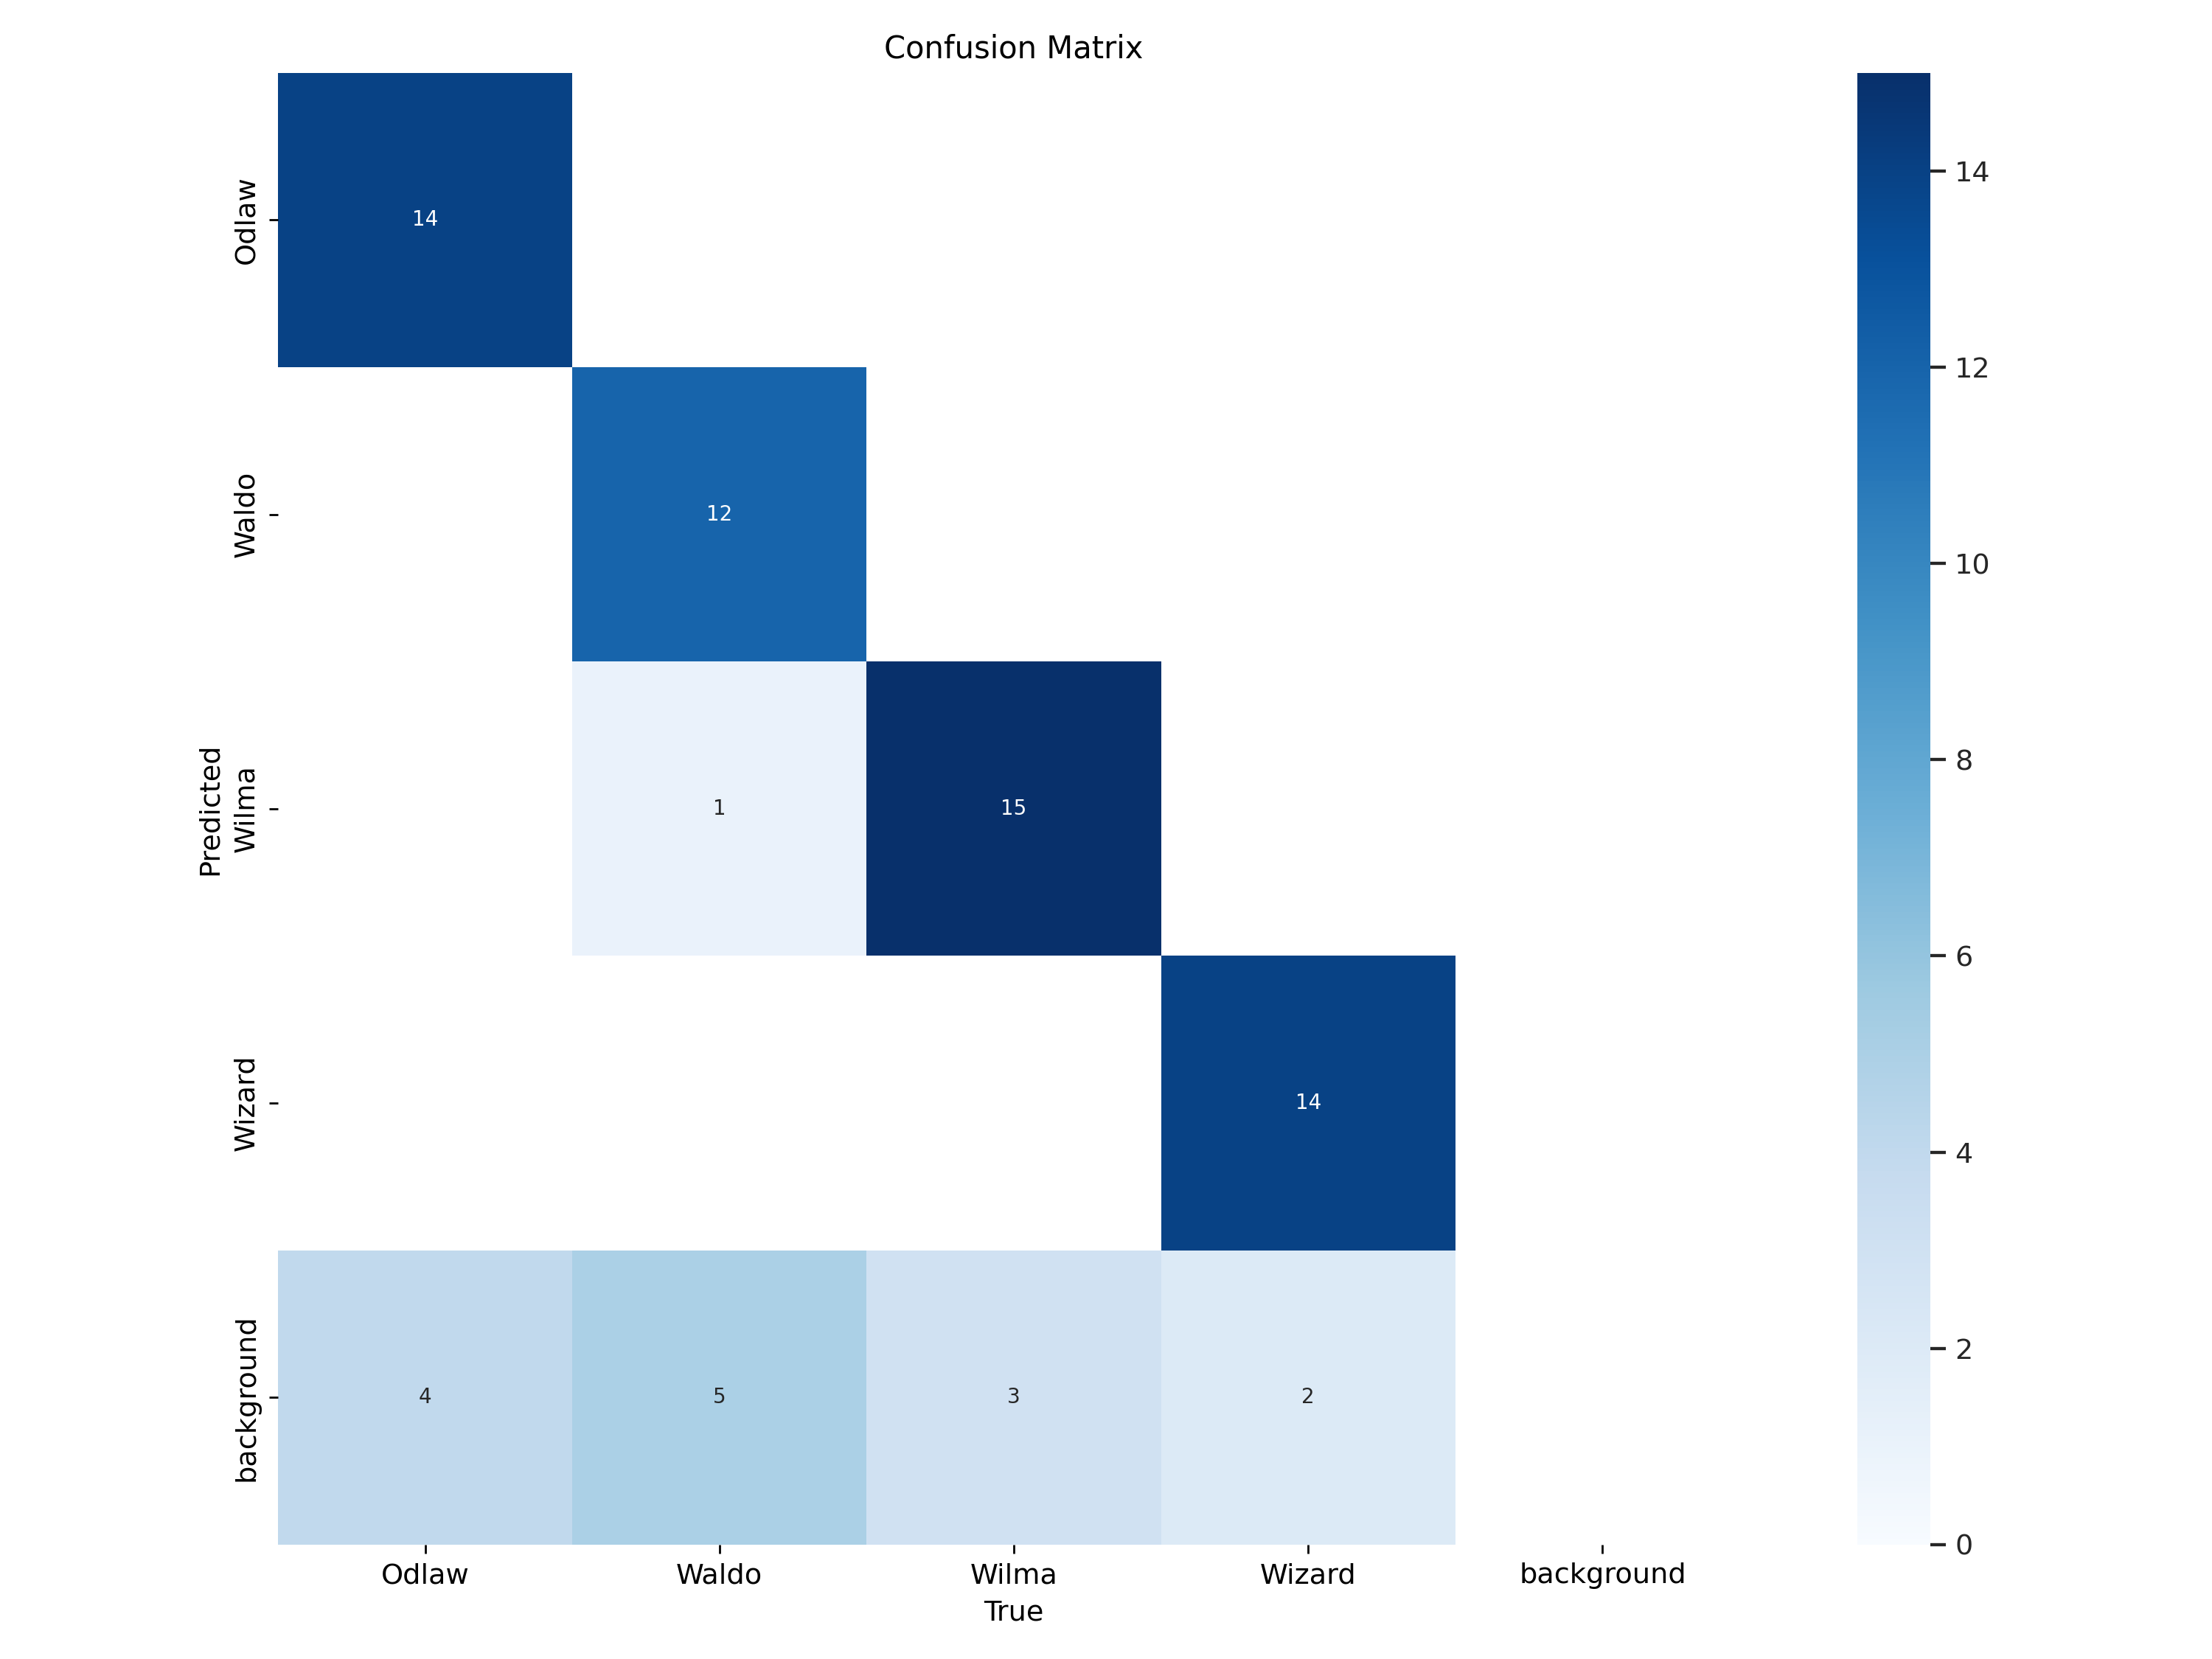

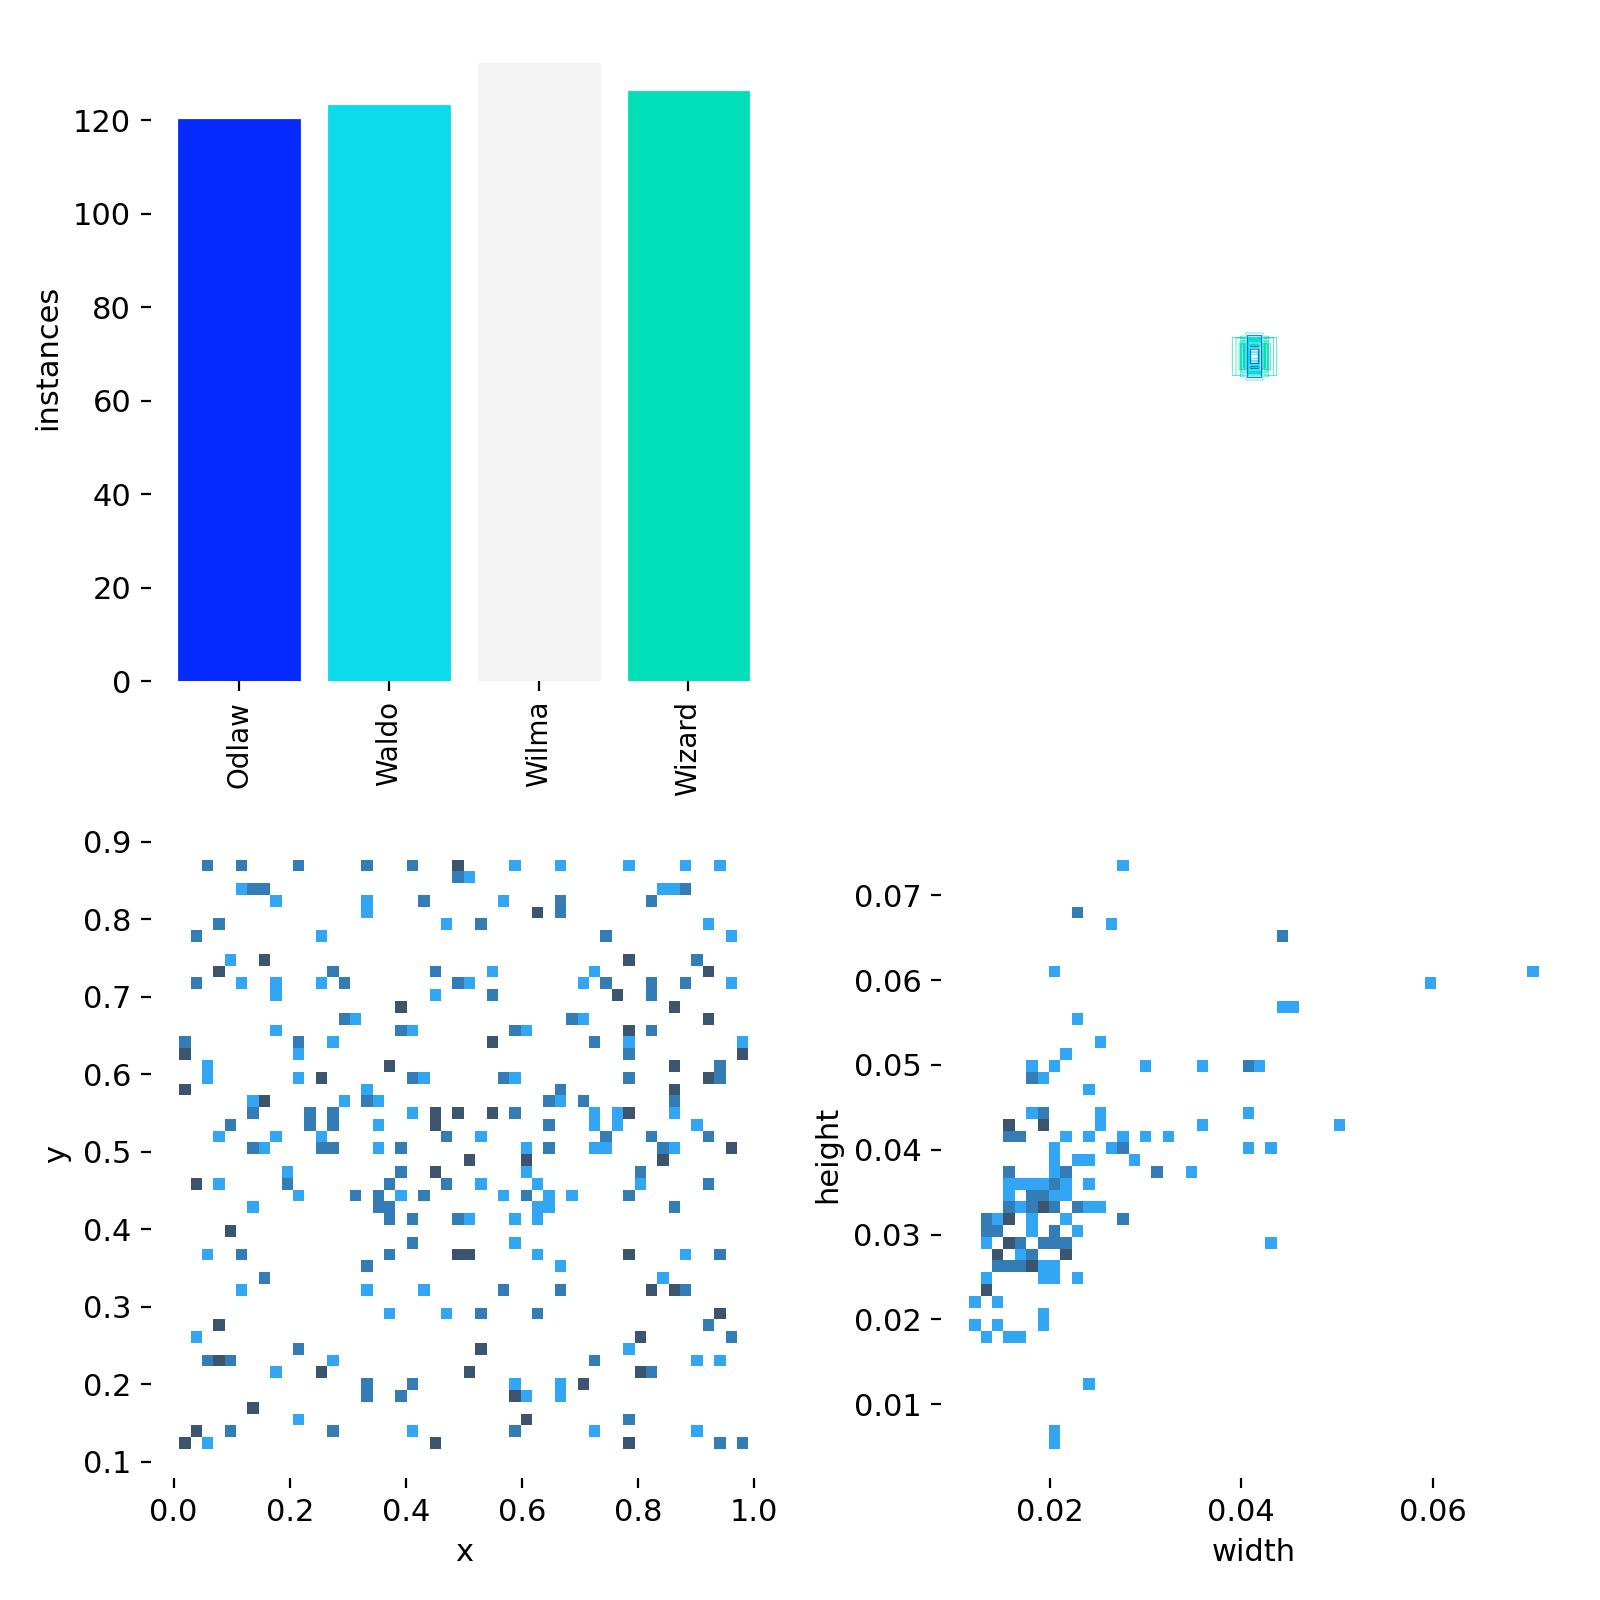

In [8]:
import os
from IPython.display import Image, display

run_dir = 'runs/detect/waldo_4c_y11x_1280'
for f in ['results.png','PR_curve.png','F1_curve.png','confusion_matrix.png','labels.jpg']:
    p = os.path.join(run_dir, f)
    if os.path.exists(p):
        display(Image(filename=p))


## **9. Backup Training Artifacts to Google Drive**
Persists the final models and training results by copying them from the temporary Colab session to a permanent backup folder in Google Drive.

In [9]:
from google.colab import drive
import shutil
import os


# Paths
src_base = '/content/runs/detect'
dst_base = '/content/drive/MyDrive/waldo_models_backup'

#Create backup folder in Drive
os.makedirs(dst_base, exist_ok=True)

# Saving Files
folders_to_copy = ['waldo_1c_y11x_1280', 'waldo_4c_y11x_1280']
for folder in folders_to_copy:
    src_path = os.path.join(src_base, folder)
    dst_path = os.path.join(dst_base, folder)
    if os.path.exists(src_path):
        shutil.copytree(src_path, dst_path, dirs_exist_ok=True)
        print(f"Saved: {dst_path}")
    else:
        print(f"Missing: {src_path}")

Saved: /content/drive/MyDrive/waldo_models_backup/waldo_1c_y11x_1280
Saved: /content/drive/MyDrive/waldo_models_backup/waldo_4c_y11x_1280


## **10. Execute Inference Pipeline on Test Images**
This final code block loads the best-performing 4-class model and runs it on a directory of unseen, full-page "Where's Waldo" images to evaluate its real-world performance. The resulting predictions, with bounding boxes drawn around detected characters, are saved to Google Drive, and a preview of the first few output images is displayed.

In [10]:
from google.colab import drive
import os, glob
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt



# ---- Paths ----
RUN_4C = "/content/runs/detect/waldo_4c_y11x_1280"
FULLPAGE_DIR = "/content/drive/MyDrive/Waldo_Fullpage"
OUT_DIR = "/content/drive/MyDrive/Waldo_Fullpage_outputs_4c"
os.makedirs(OUT_DIR, exist_ok=True)

# ---- Find latest best.pt inside run ----
def latest_best(run_root):
    cands = glob.glob(os.path.join(run_root, "**", "weights", "best.pt"), recursive=True)
    if not cands:
        raise FileNotFoundError(f"No best.pt found under {run_root}")
    return max(cands, key=os.path.getmtime)

best_weights = latest_best(RUN_4C)
print("Using 4-class model weights:", best_weights)

# ---- Load YOLO model ----
model = YOLO(best_weights)

# ---- Run detection ----
results = model.predict(
    source=FULLPAGE_DIR,
    imgsz=1280,
    conf=0.5,
    save=True,
    project=OUT_DIR,
    name="predictions",
    exist_ok=True
)

print("Detection complete. Results saved in:", os.path.join(OUT_DIR, "predictions"))

Using 4-class model weights: /content/runs/detect/waldo_4c_y11x_1280/weights/best.pt

image 1/83 /content/drive/MyDrive/Waldo_Fullpage/1.jpg: 800x1280 (no detections), 3402.7ms
image 2/83 /content/drive/MyDrive/Waldo_Fullpage/10.jpg: 800x1280 1 Wilma, 35.7ms
image 3/83 /content/drive/MyDrive/Waldo_Fullpage/10_png_jpg.rf.26d5008a39a33d3254a4569405f54e6b.jpg: 1280x1280 (no detections), 27.4ms
image 4/83 /content/drive/MyDrive/Waldo_Fullpage/10_png_jpg.rf.54111a0d6eaa4ff157eeebc9459591c6.jpg: 1280x1280 (no detections), 25.7ms
image 5/83 /content/drive/MyDrive/Waldo_Fullpage/10_png_jpg.rf.d36e6b0e5d921fa1eeb20f7e13b51f9e.jpg: 1280x1280 (no detections), 25.7ms
image 6/83 /content/drive/MyDrive/Waldo_Fullpage/10_png_jpg.rf.ea67d934438cbe2123076b8b32a60be0.jpg: 1280x1280 1 Odlaw, 25.7ms
image 7/83 /content/drive/MyDrive/Waldo_Fullpage/11.jpg: 832x1280 1 Waldo, 1 Wilma, 3422.3ms
image 8/83 /content/drive/MyDrive/Waldo_Fullpage/11_png_jpg.rf.1a582556f8477f4a4d2bd4a8f0049660.jpg: 1280x1280 1 Wiz